# Some integration tests for biologically plausible winner-take-all algorithm (`BioWTARegressor`)

In [1]:
%matplotlib inline
import time
import timeit
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace
from typing import Sequence, Callable, Tuple, Optional
from tqdm.notebook import tqdm

from sklearn import metrics

from bioslds.arma_hsmm import ArmaHSMM, sample_switching_models
from bioslds.arma import make_random_arma, Arma
from bioslds.regressors import BioWTARegressor, fit_infer_ar
from bioslds import sources
from bioslds.plotting import FigureManager, show_latent
from bioslds.cluster_quality import calculate_sliding_score, unordered_accuracy_score
from bioslds.dataset import RandomArmaDataset

## Check performance on pure regression problem

In [2]:
rng = np.random.default_rng(0)

pure_reg = SimpleNamespace(n_samples=30_000, n_features=4, n_models=2, streak_len=1000)
pure_reg.models = []
pure_reg.predictors = rng.normal(size=(pure_reg.n_samples, pure_reg.n_features))
pure_reg.noise = 0.1 * rng.normal(size=(pure_reg.n_samples))
pure_reg.usage_seq = (np.arange(pure_reg.n_samples) / pure_reg.streak_len).astype(
    int
) % pure_reg.n_models
pure_reg.seq0 = np.zeros(pure_reg.n_samples)
for i in range(pure_reg.n_models):
    crt_model = rng.normal(size=pure_reg.n_features)
    pure_reg.models.append(crt_model)

    mask = pure_reg.usage_seq == i
    pure_reg.seq0[mask] = pure_reg.predictors[mask, :] @ crt_model

pure_reg.seq = pure_reg.seq0 + pure_reg.noise

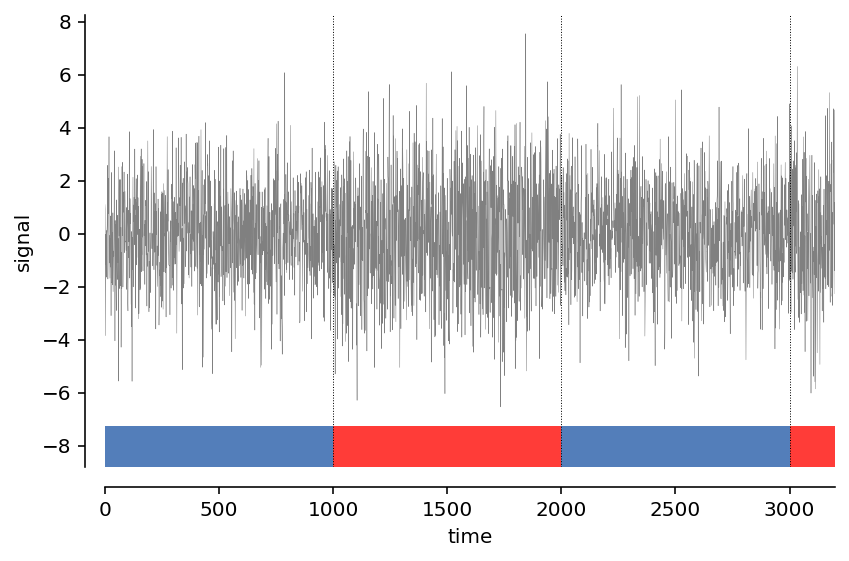

In [3]:
with FigureManager() as (_, ax):
    ax.plot(pure_reg.seq[:3200], lw=0.25, c="gray")
    ax.set_xlim(0, 3200)
    show_latent(pure_reg.usage_seq, bar_location="bottom")

    ax.set_xlabel("time")
    ax.set_ylabel("signal")

In [4]:
pure_reg.regressor = BioWTARegressor(pure_reg.n_models, pure_reg.n_features)
pure_reg.inferred_r = pure_reg.regressor.fit_infer(pure_reg.predictors, pure_reg.seq)
pure_reg.inferred_usage = np.argmax(pure_reg.inferred_r, axis=1)

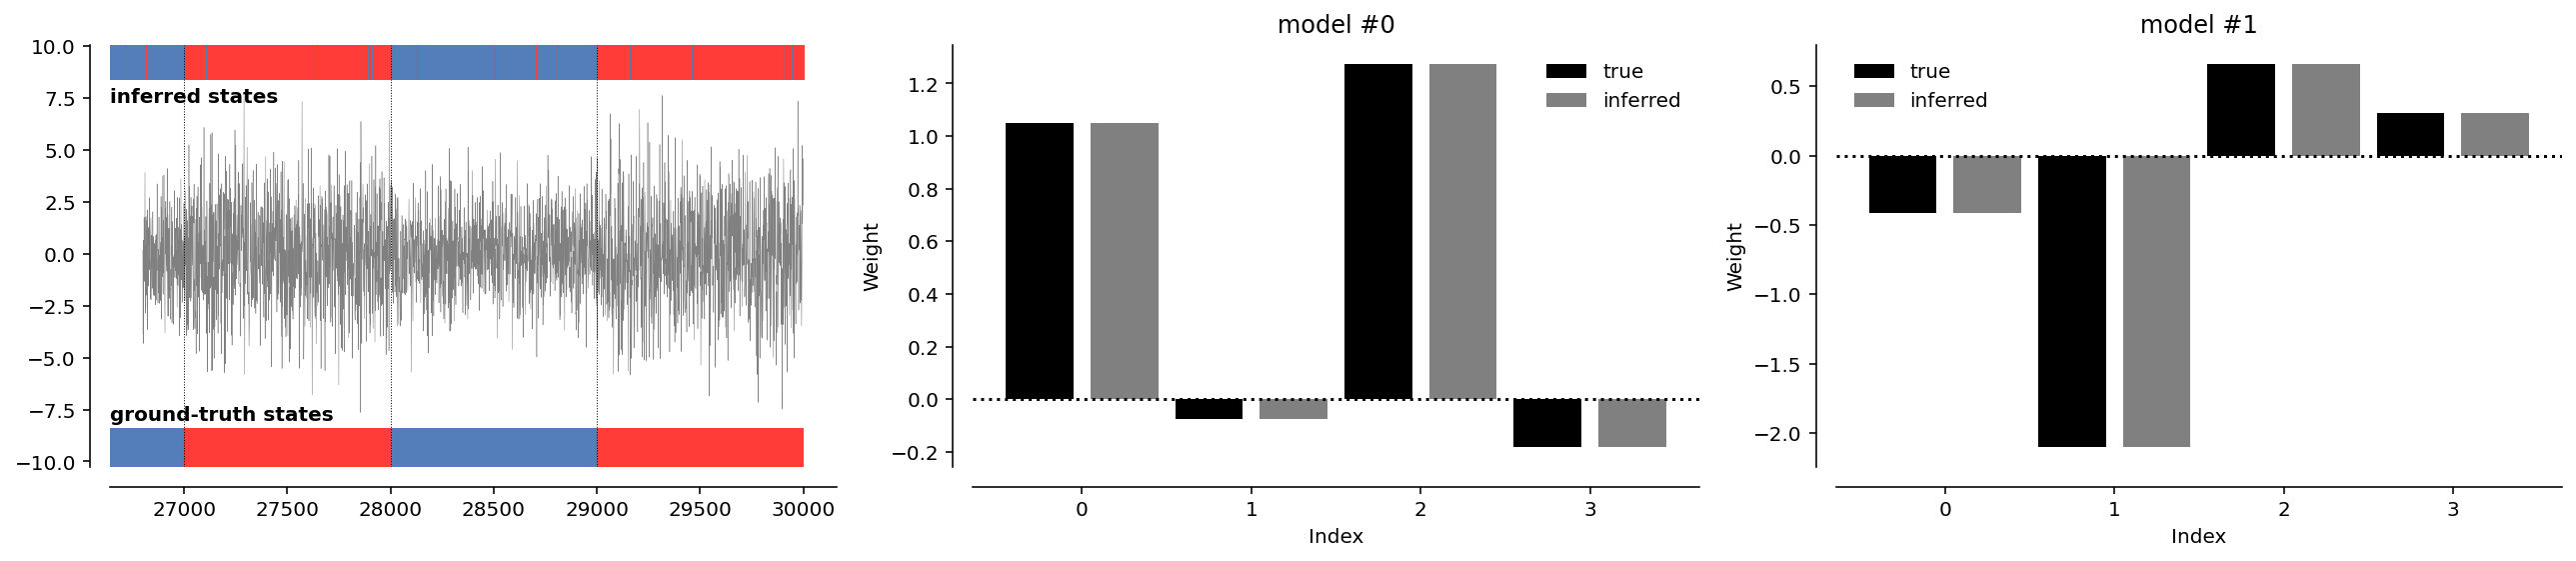

In [5]:
with FigureManager(1, pure_reg.n_models + 1) as (_, axs):
    axs[0].plot(
        np.arange(pure_reg.n_samples - 3200, pure_reg.n_samples),
        pure_reg.seq[-3200:],
        lw=0.25,
        c="gray",
    )
    show_latent(
        pure_reg.inferred_usage, show_vlines=False, shift=pure_reg.n_features, ax=axs[0]
    )
    show_latent(pure_reg.usage_seq, bar_location="bottom", ax=axs[0])

    axs[0].annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    axs[0].annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

    used_models = set()
    for i in range(pure_reg.n_models):
        ax = axs[i + 1]

        crt_model = pure_reg.models[i]

        # find fitted model that best matches the real model
        crt_corrs = -np.inf * np.ones(pure_reg.n_models)
        for k in range(pure_reg.n_models):
            if k in used_models:
                continue
            crt_corrs[k] = np.corrcoef(crt_model, pure_reg.regressor.weights_[k])[0, 1]

        i_match = crt_corrs.argmax()
        used_models.add(i_match)

        ax.bar(
            np.arange(pure_reg.n_features) - 0.25,
            crt_model,
            width=0.4,
            label="true",
            fc="k",
        )
        ax.bar(
            np.arange(pure_reg.n_features) + 0.25,
            pure_reg.regressor.weights_[i_match],
            width=0.4,
            label="inferred",
            fc="gray",
        )
        ax.axhline(0, c="k", ls=":")

        ax.set_title(f"model #{i}")

        ax.legend(frameon=False)
        ax.set_xticks(np.arange(pure_reg.n_features))

        ax.set_xlabel("Index")
        ax.set_ylabel("Weight")

In [6]:
pure_reg.score_loc, pure_reg.score = calculate_sliding_score(
    metrics.adjusted_rand_score,
    pure_reg.usage_seq,
    pure_reg.inferred_usage,
    window_size=5000,
    progress=tqdm,
)

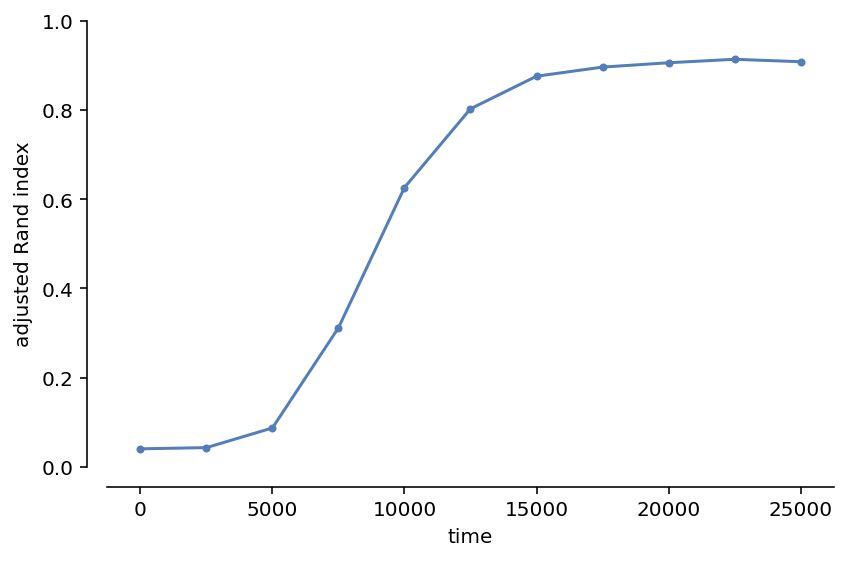

In [7]:
with FigureManager() as (_, ax):
    ax.plot(pure_reg.score_loc, pure_reg.score, '.-')
    ax.set_xlabel("time")
    ax.set_ylabel("adjusted Rand index")
    ax.set_ylim(0, 1)

In [8]:
pure_reg.score_loc_acc, pure_reg.score_acc = calculate_sliding_score(
    unordered_accuracy_score,
    pure_reg.usage_seq,
    pure_reg.inferred_usage,
    window_size=5000,
    progress=tqdm,
)

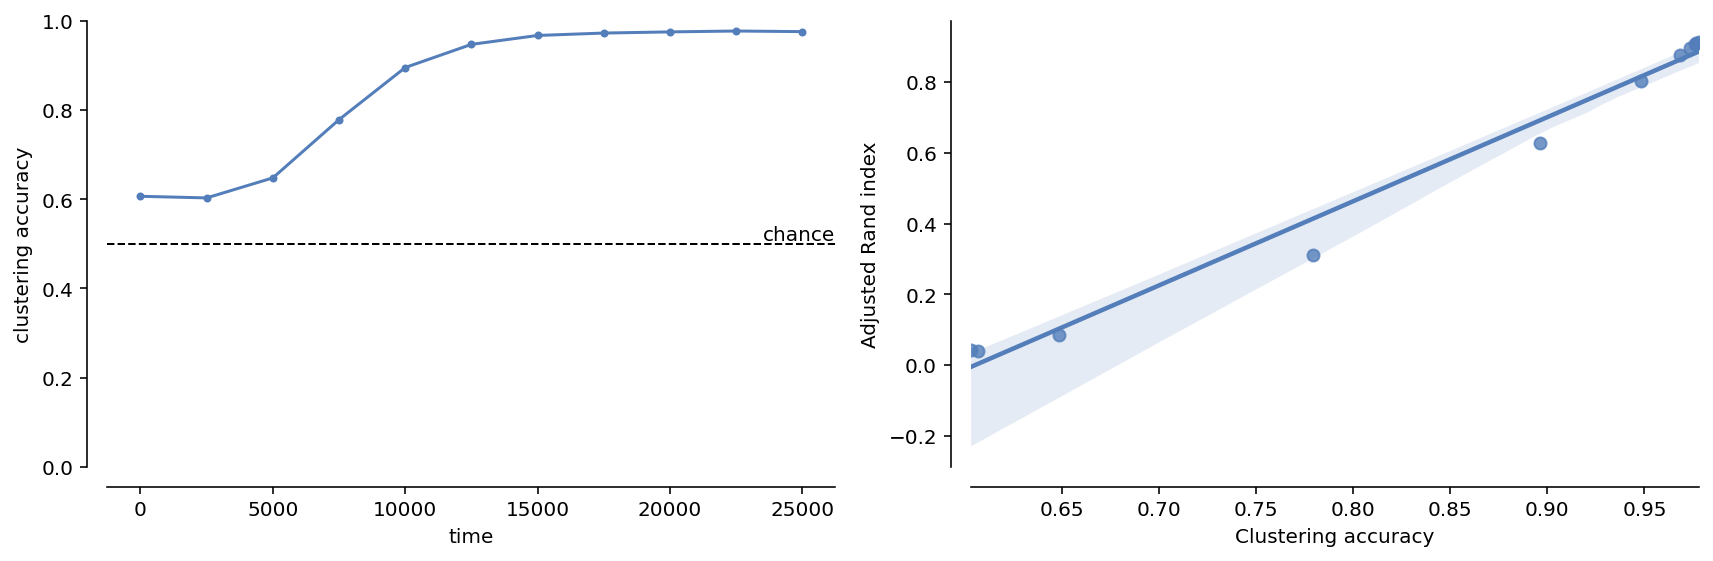

In [9]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(pure_reg.score_loc_acc, pure_reg.score_acc, ".-")
    ax1.set_xlabel("time")
    ax1.set_ylabel("clustering accuracy")
    ax1.axhline(0.5, ls="--", lw=1, c="k")
    ax1.annotate(
        "chance",
        (ax.get_xlim()[1], 0.5),
        horizontalalignment="right",
        verticalalignment="bottom",
    )
    ax1.set_ylim(0, 1)
    
    sns.regplot(pure_reg.score_acc, pure_reg.score, ax=ax2)
    ax2.set_xlabel("Clustering accuracy")
    ax2.set_ylabel("Adjusted Rand index")

## Check performance on randomly switching AR(3)s

In [10]:
rng = np.random.default_rng(1)

two_ar3 = SimpleNamespace(
    arma1=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(1)),
    arma2=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(2)),
    n_samples=100_000,
    n_features=3,
)
two_ar3.models = [two_ar3.arma1, two_ar3.arma2]
two_ar3.arma_hsmm = ArmaHSMM(two_ar3.models, min_dwell=15, dwell_times=50,)
two_ar3.n_models = len(two_ar3.models)

(two_ar3.sig, two_ar3.u, two_ar3.usage_seq,) = two_ar3.arma_hsmm.transform(
    two_ar3.n_samples
)

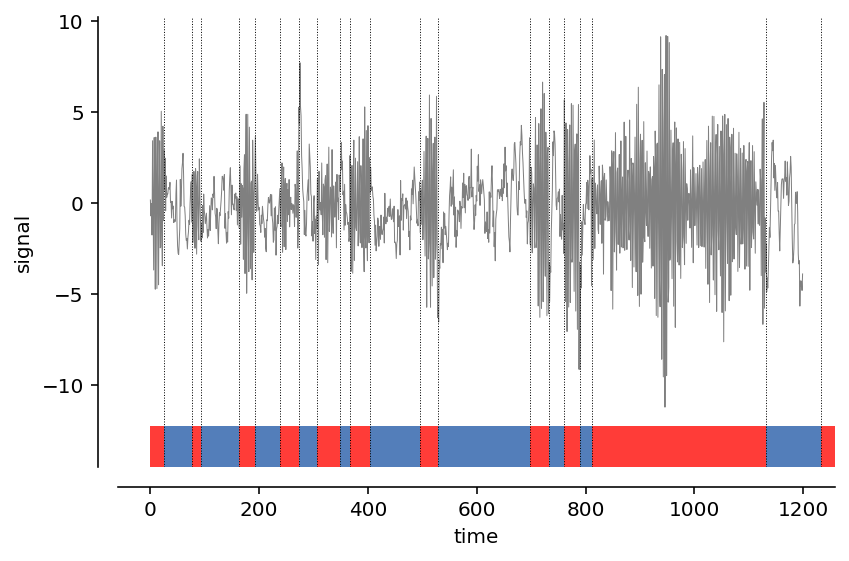

In [11]:
with FigureManager() as (_, ax):
    ax.plot(two_ar3.sig[:1200], c="gray", lw=0.5)
    ax.set_xlabel("time")
    ax.set_ylabel("signal")

    show_latent(two_ar3.usage_seq, bar_location="bottom", ax=ax)

In [12]:
two_ar3.regressor = BioWTARegressor(two_ar3.n_models, two_ar3.n_features)
two_ar3.inferred_r, two_ar3.history = fit_infer_ar(
    two_ar3.regressor, two_ar3.sig, progress=tqdm, monitor=["weights_"],
)
two_ar3.inferred_usage = np.argmax(two_ar3.inferred_r, axis=1)

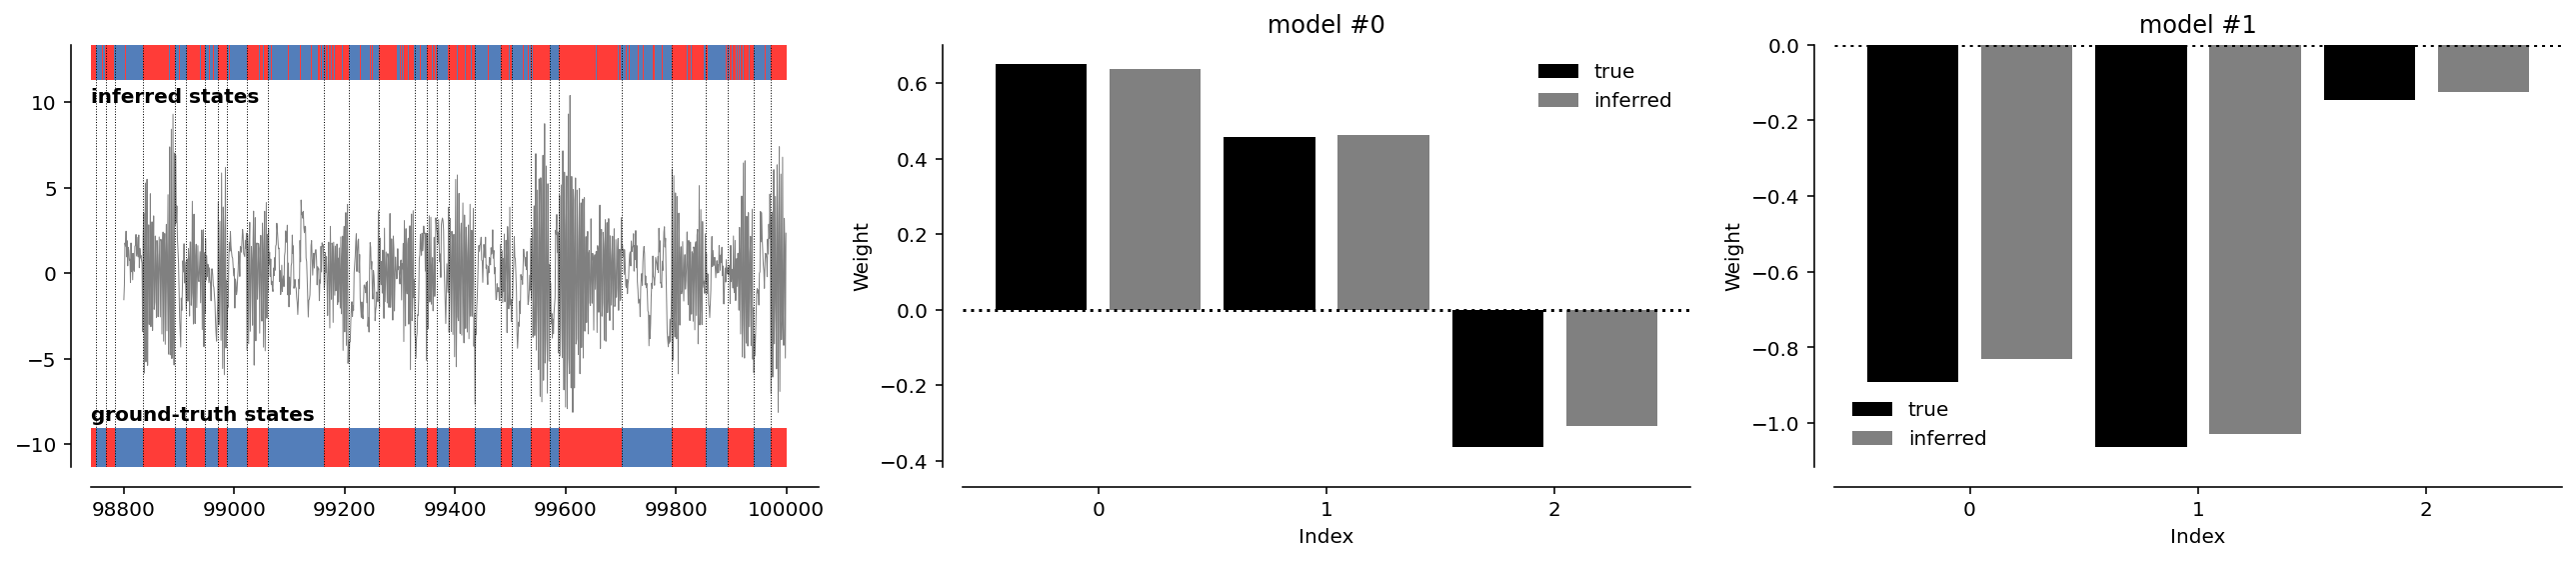

In [13]:
with FigureManager(1, two_ar3.n_models + 1) as (_, axs):
    axs[0].plot(
        np.arange(two_ar3.n_samples - 1200, two_ar3.n_samples),
        two_ar3.sig[-1200:],
        lw=0.5,
        c="gray",
    )
    show_latent(
        two_ar3.inferred_usage, show_vlines=False, shift=two_ar3.n_features, ax=axs[0]
    )
    show_latent(two_ar3.usage_seq, bar_location="bottom", ax=axs[0])

    axs[0].annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    axs[0].annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

    used_models = set()
    for i in range(two_ar3.n_models):
        ax = axs[i + 1]

        crt_model = two_ar3.models[i].a

        # find fitted model that best matches the real model
        crt_corrs = -np.inf * np.ones(two_ar3.n_models)
        for k in range(two_ar3.n_models):
            if k in used_models:
                continue
            crt_corrs[k] = np.corrcoef(crt_model, two_ar3.regressor.weights_[k])[0, 1]

        i_match = crt_corrs.argmax()
        used_models.add(i_match)

        ax.bar(
            np.arange(two_ar3.n_features) - 0.25,
            crt_model,
            width=0.4,
            label="true",
            fc="k",
        )
        ax.bar(
            np.arange(two_ar3.n_features) + 0.25,
            two_ar3.regressor.weights_[i_match],
            width=0.4,
            label="inferred",
            fc="gray",
        )
        ax.axhline(0, c="k", ls=":")
        
        ax.set_title(f"model #{i}")

        ax.legend(frameon=False)
        ax.set_xticks(np.arange(two_ar3.n_features))

        ax.set_xlabel("Index")
        ax.set_ylabel("Weight")

In [14]:
two_ar3.score_loc, two_ar3.score = calculate_sliding_score(
    metrics.adjusted_rand_score,
    two_ar3.usage_seq,
    two_ar3.inferred_usage,
    progress=tqdm,
)

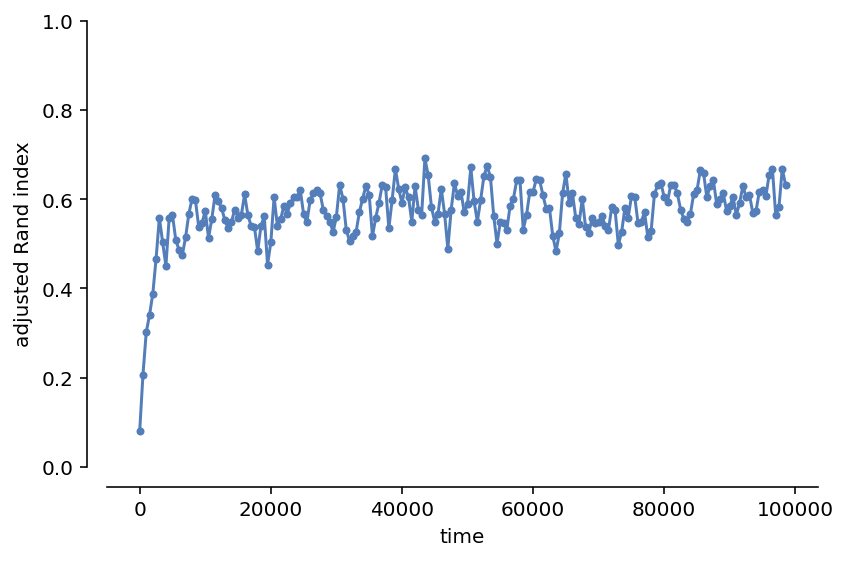

In [15]:
with FigureManager() as (_, ax):
    ax.plot(two_ar3.score_loc, two_ar3.score, '.-')
    ax.set_xlabel("time")
    ax.set_ylabel("adjusted Rand index")
    ax.set_ylim(0, 1)

In [16]:
two_ar3.score_loc_acc, two_ar3.score_acc = calculate_sliding_score(
    unordered_accuracy_score,
    two_ar3.usage_seq,
    two_ar3.inferred_usage,
    progress=tqdm,
)

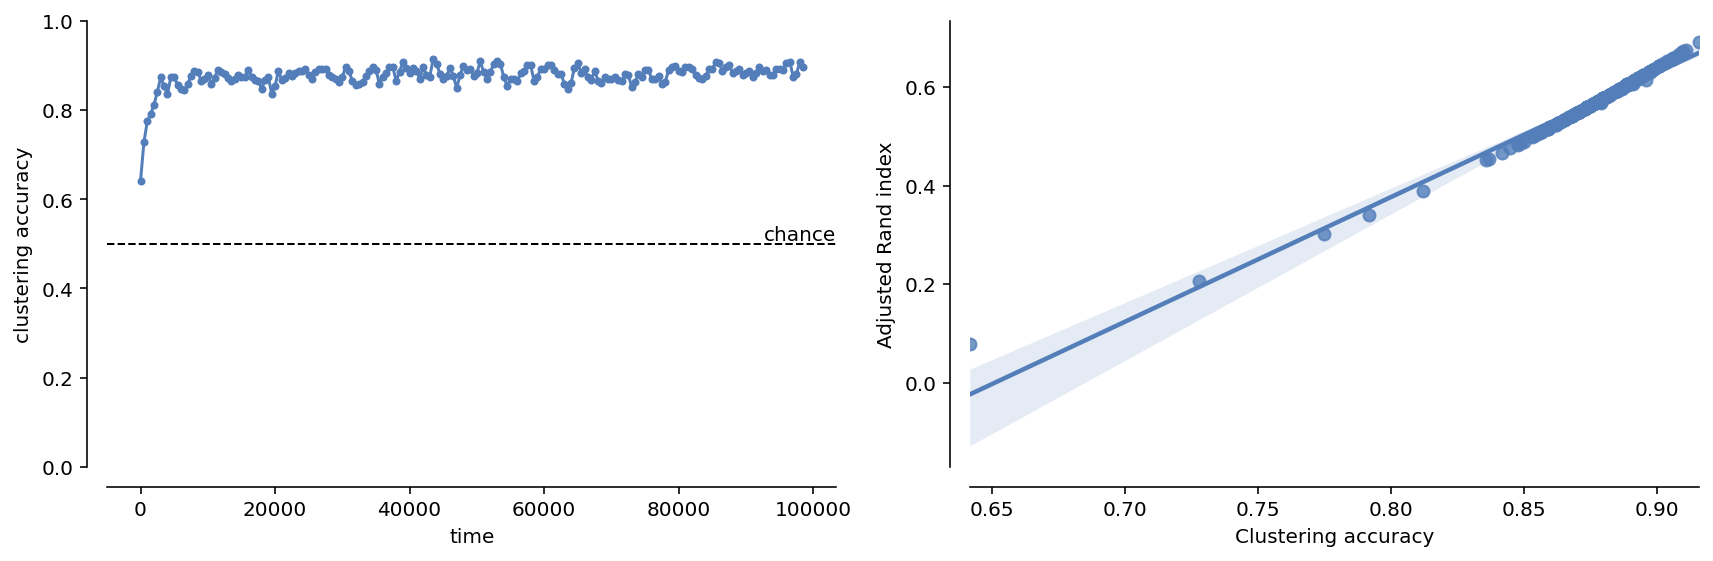

In [17]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(two_ar3.score_loc_acc, two_ar3.score_acc, ".-")
    ax1.set_xlabel("time")
    ax1.set_ylabel("clustering accuracy")
    ax1.axhline(0.5, ls="--", lw=1, c="k")
    ax1.annotate(
        "chance",
        (ax.get_xlim()[1], 0.5),
        horizontalalignment="right",
        verticalalignment="bottom",
    )
    ax1.set_ylim(0, 1)
    
    sns.regplot(two_ar3.score_acc, two_ar3.score, ax=ax2)
    ax2.set_xlabel("Clustering accuracy")
    ax2.set_ylabel("Adjusted Rand index")

## Randomly switching AR(3)s with non-trivial latent Markov parameters

Here we are encouraging longer dwelling times per state, avoiding fluctuations in the inferred latent states.

In [18]:
rng = np.random.default_rng(1)

two_ar3_bias_markov = SimpleNamespace(
    arma1=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(1)),
    arma2=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(2)),
    n_samples=100_000,
    n_features=3,
    regressor_expected_dwell=50,
)
two_ar3_bias_markov.models = [two_ar3_bias_markov.arma1, two_ar3_bias_markov.arma2]
two_ar3_bias_markov.arma_hsmm = ArmaHSMM(
    two_ar3_bias_markov.models, min_dwell=15, dwell_times=50,
)
two_ar3_bias_markov.n_models = len(two_ar3_bias_markov.models)

(
    two_ar3_bias_markov.sig,
    two_ar3_bias_markov.u,
    two_ar3_bias_markov.usage_seq,
) = two_ar3_bias_markov.arma_hsmm.transform(two_ar3_bias_markov.n_samples)

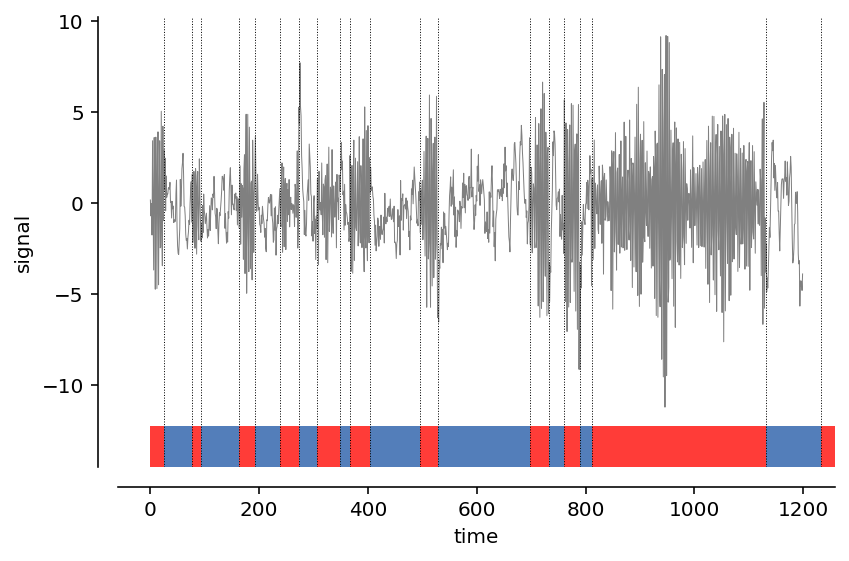

In [19]:
with FigureManager() as (_, ax):
    ax.plot(two_ar3_bias_markov.sig[:1200], c="gray", lw=0.5)
    ax.set_xlabel("time")
    ax.set_ylabel("signal")

    show_latent(two_ar3_bias_markov.usage_seq, bar_location="bottom", ax=ax)

In [20]:
two_ar3_bias_markov.regressor = BioWTARegressor(
    two_ar3_bias_markov.n_models,
    two_ar3_bias_markov.n_features,
    trans_mat=1 - 1 / two_ar3_bias_markov.regressor_expected_dwell,
)
two_ar3_bias_markov.inferred_r, two_ar3_bias_markov.history = fit_infer_ar(
    two_ar3_bias_markov.regressor,
    two_ar3_bias_markov.sig,
    progress=tqdm,
    monitor=["weights_"],
)
two_ar3_bias_markov.inferred_usage = np.argmax(two_ar3_bias_markov.inferred_r, axis=1)

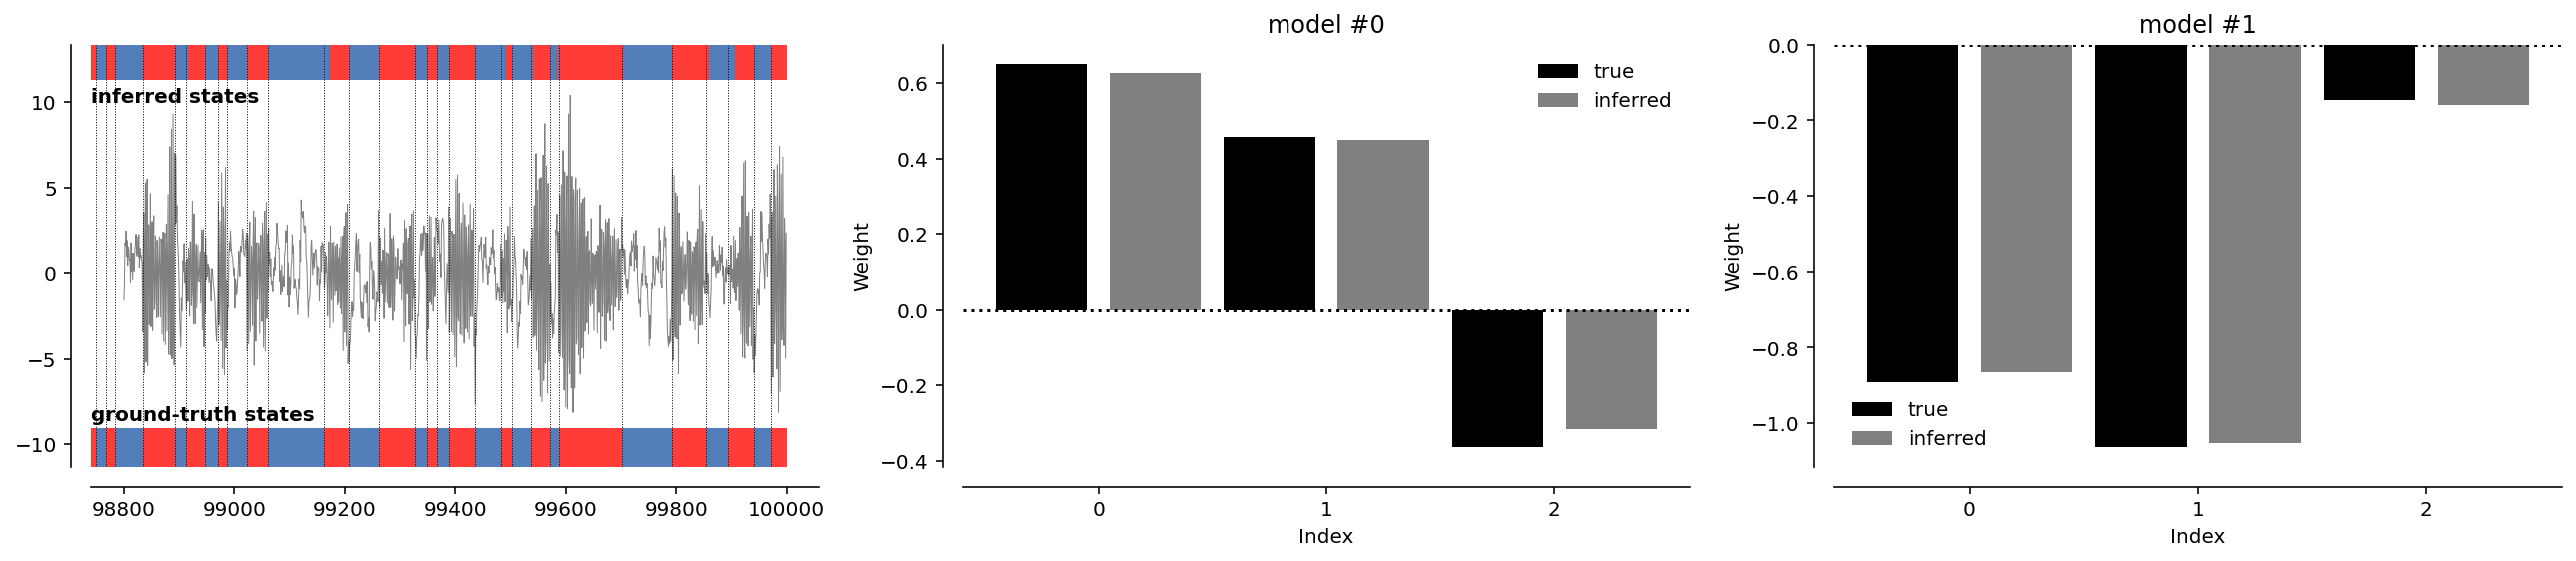

In [21]:
with FigureManager(1, two_ar3_bias_markov.n_models + 1) as (_, axs):
    axs[0].plot(
        np.arange(two_ar3_bias_markov.n_samples - 1200, two_ar3_bias_markov.n_samples),
        two_ar3_bias_markov.sig[-1200:],
        lw=0.5,
        c="gray",
    )
    show_latent(
        two_ar3_bias_markov.inferred_usage,
        show_vlines=False,
        shift=two_ar3_bias_markov.n_features,
        ax=axs[0],
    )
    show_latent(two_ar3_bias_markov.usage_seq, bar_location="bottom", ax=axs[0])

    axs[0].annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    axs[0].annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

    used_models = set()
    for i in range(two_ar3_bias_markov.n_models):
        ax = axs[i + 1]

        crt_model = two_ar3_bias_markov.models[i].a

        # find fitted model that best matches the real model
        crt_corrs = -np.inf * np.ones(two_ar3_bias_markov.n_models)
        for k in range(two_ar3_bias_markov.n_models):
            if k in used_models:
                continue
            crt_corrs[k] = np.corrcoef(
                crt_model, two_ar3_bias_markov.regressor.weights_[k]
            )[0, 1]

        i_match = crt_corrs.argmax()
        used_models.add(i_match)

        ax.bar(
            np.arange(two_ar3_bias_markov.n_features) - 0.25,
            crt_model,
            width=0.4,
            label="true",
            fc="k",
        )
        ax.bar(
            np.arange(two_ar3_bias_markov.n_features) + 0.25,
            two_ar3_bias_markov.regressor.weights_[i_match],
            width=0.4,
            label="inferred",
            fc="gray",
        )
        ax.axhline(0, c="k", ls=":")
        
        ax.set_title(f"model #{i}")

        ax.legend(frameon=False)
        ax.set_xticks(np.arange(two_ar3_bias_markov.n_features))

        ax.set_xlabel("Index")
        ax.set_ylabel("Weight")

In [22]:
two_ar3_bias_markov.score_loc, two_ar3_bias_markov.score = calculate_sliding_score(
    metrics.adjusted_rand_score,
    two_ar3_bias_markov.usage_seq,
    two_ar3_bias_markov.inferred_usage,
    progress=tqdm,
)

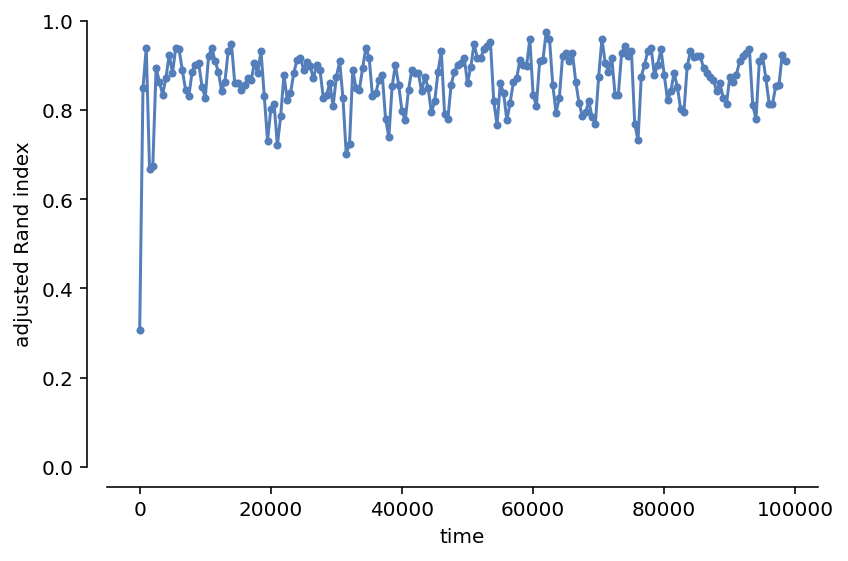

In [23]:
with FigureManager() as (_, ax):
    ax.plot(two_ar3_bias_markov.score_loc, two_ar3_bias_markov.score, '.-')
    ax.set_xlabel("time")
    ax.set_ylabel("adjusted Rand index")
    ax.set_ylim(0, 1)

In [24]:
two_ar3_bias_markov.score_loc_acc, two_ar3_bias_markov.score_acc = calculate_sliding_score(
    unordered_accuracy_score,
    two_ar3_bias_markov.usage_seq,
    two_ar3_bias_markov.inferred_usage,
    progress=tqdm,
)

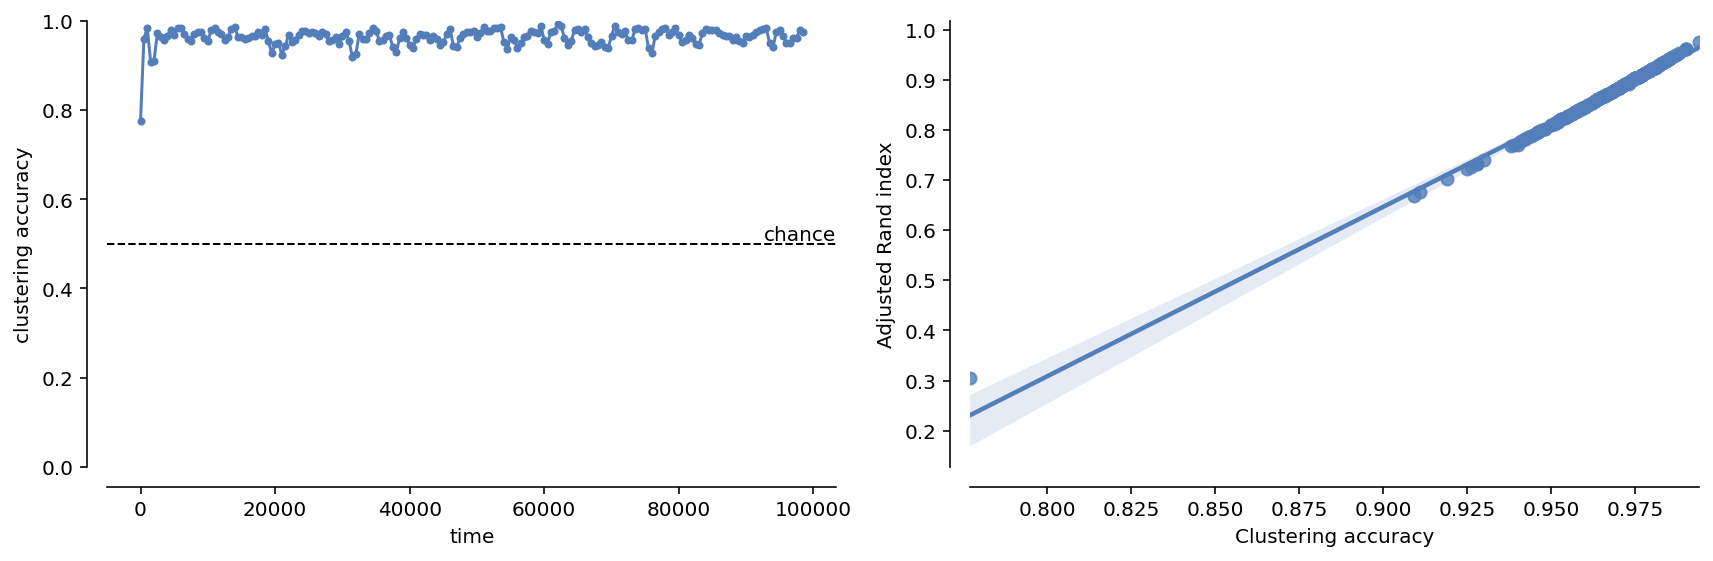

In [25]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(two_ar3_bias_markov.score_loc_acc, two_ar3_bias_markov.score_acc, ".-")
    ax1.set_xlabel("time")
    ax1.set_ylabel("clustering accuracy")
    ax1.axhline(0.5, ls="--", lw=1, c="k")
    ax1.annotate(
        "chance",
        (ax.get_xlim()[1], 0.5),
        horizontalalignment="right",
        verticalalignment="bottom",
    )
    ax1.set_ylim(0, 1)
    
    sns.regplot(two_ar3_bias_markov.score_acc, two_ar3_bias_markov.score, ax=ax2)
    ax2.set_xlabel("Clustering accuracy")
    ax2.set_ylabel("Adjusted Rand index")

## Check performance on 2x AR(1)s with switching means

In [26]:
rng = np.random.default_rng(1)

two_ar1_nonzero_mean = SimpleNamespace(
    arma1=Arma([0.97], [], bias=1.0, default_source=sources.GaussianNoise(1)),
    arma2=Arma([0.97], [], bias=-1.0, default_source=sources.GaussianNoise(1)),
    n_samples=600_000,
    n_features=1,
    streak_len=40,
)
two_ar1_nonzero_mean.models = [
    two_ar1_nonzero_mean.arma1,
    two_ar1_nonzero_mean.arma2,
]
two_ar1_nonzero_mean.n_models = len(two_ar1_nonzero_mean.models)
two_ar1_nonzero_mean.usage_seq = np.repeat(
    (two_ar1_nonzero_mean.n_samples // (2 * two_ar1_nonzero_mean.streak_len)) * [0, 1],
    two_ar1_nonzero_mean.streak_len,
)
two_ar1_nonzero_mean.sig, two_ar1_nonzero_mean.u = sample_switching_models(
    two_ar1_nonzero_mean.models, two_ar1_nonzero_mean.usage_seq
)

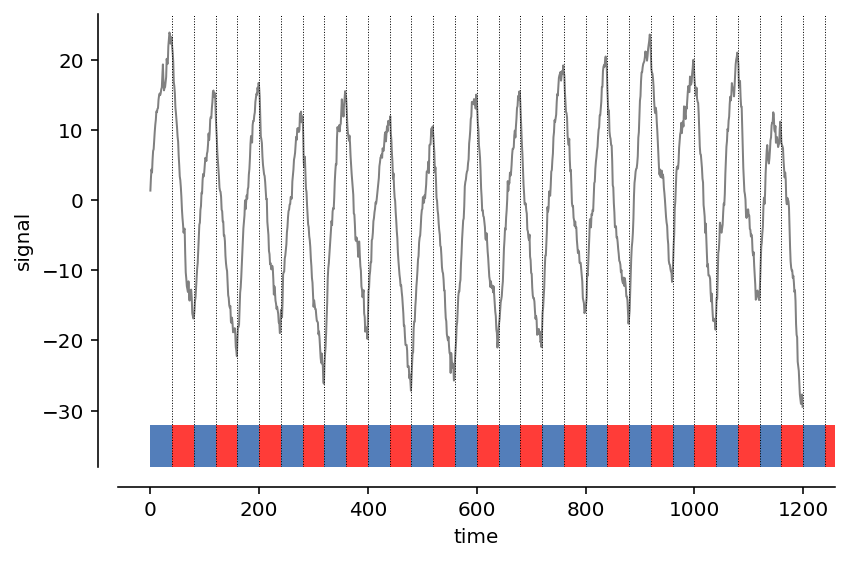

In [27]:
with FigureManager() as (_, ax):
    ax.plot(two_ar1_nonzero_mean.sig[:1200], c="gray", lw=1)
    ax.set_xlabel("time")
    ax.set_ylabel("signal")

    show_latent(two_ar1_nonzero_mean.usage_seq, bar_location="bottom", ax=ax)

In [28]:
two_ar1_nonzero_mean.regressor = BioWTARegressor(
    two_ar1_nonzero_mean.n_models,
    two_ar1_nonzero_mean.n_features + 1,  # +1 for bias
    rate_weights=0.001,
    trans_mat=0.8,
)
two_ar1_nonzero_mean.inferred_r, two_ar1_nonzero_mean.history = fit_infer_ar(
    two_ar1_nonzero_mean.regressor,
    two_ar1_nonzero_mean.sig,
    bias=True,
    progress=tqdm,
    monitor=["weights_"],
)
two_ar1_nonzero_mean.inferred_usage = np.argmax(two_ar1_nonzero_mean.inferred_r, axis=1)

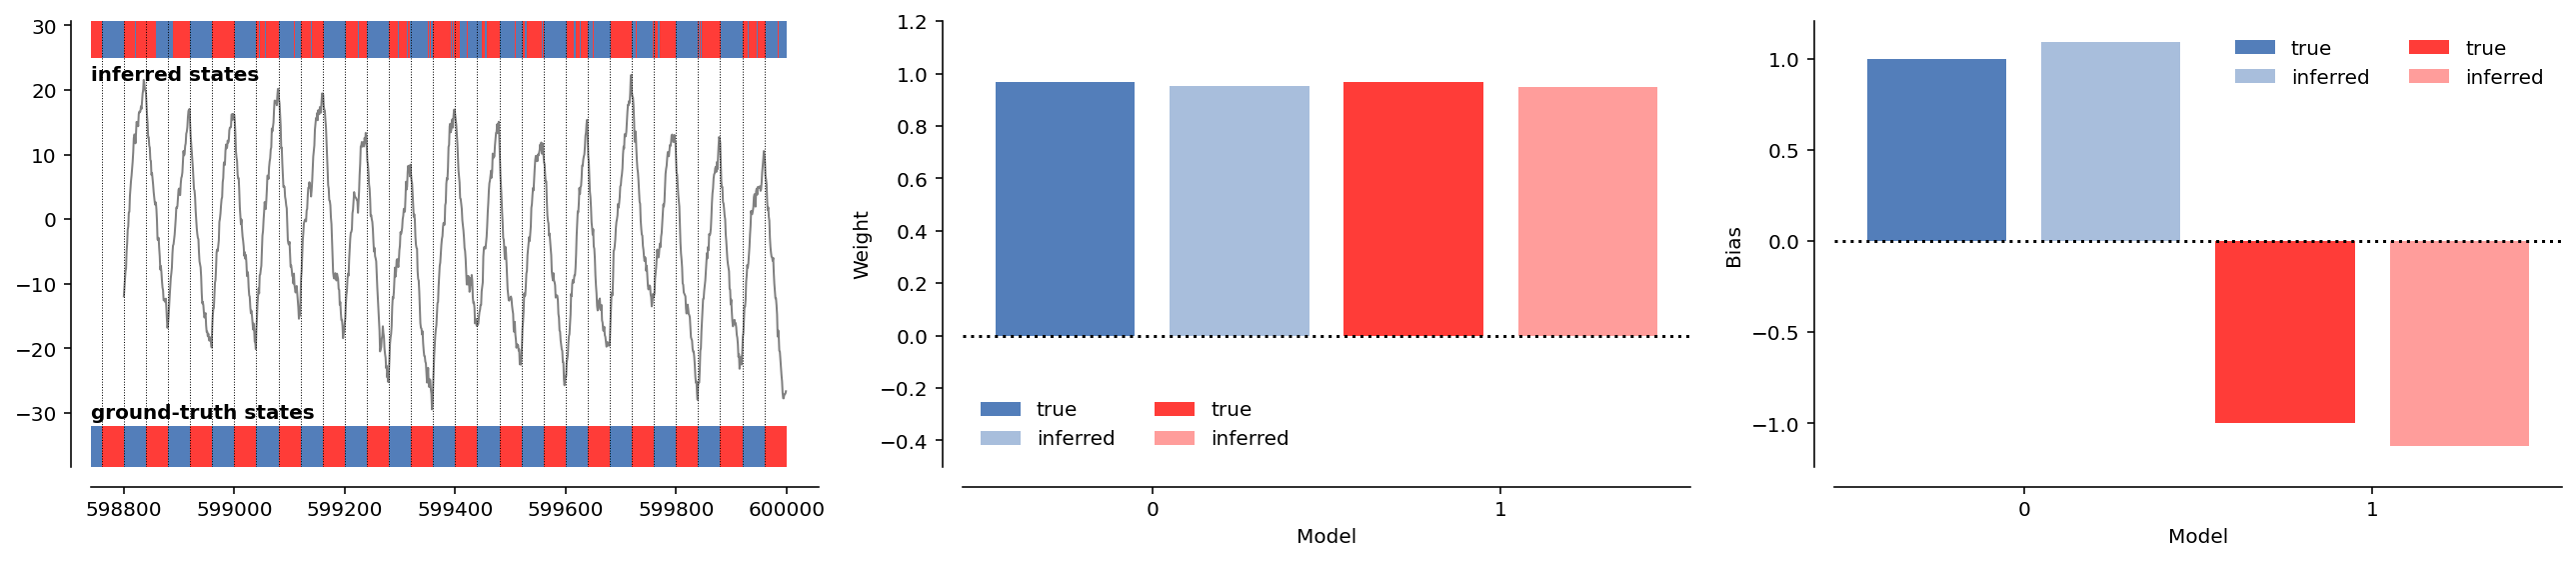

In [29]:
with FigureManager(1, 3) as (_, axs):
    axs[0].plot(
        np.arange(
            two_ar1_nonzero_mean.n_samples - 1200, two_ar1_nonzero_mean.n_samples
        ),
        two_ar1_nonzero_mean.sig[-1200:],
        c="gray",
        lw=1,
    )
    show_latent(
        two_ar1_nonzero_mean.inferred_usage,
        show_vlines=False,
        shift=two_ar1_nonzero_mean.n_features,
        ax=axs[0],
    )
    show_latent(two_ar1_nonzero_mean.usage_seq, bar_location="bottom", ax=axs[0])
    
    axs[0].annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    axs[0].annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

    i_matches = []
    for i in range(two_ar1_nonzero_mean.n_models):
        crt_model = [
            two_ar1_nonzero_mean.models[i].a[0],
            two_ar1_nonzero_mean.models[i].bias,
        ]

        # find fitted model that best matches the real model
        crt_corrs = np.inf * np.ones(two_ar1_nonzero_mean.n_models)
        for k in range(two_ar1_nonzero_mean.n_models):
            if k in i_matches:
                continue
            crt_corrs[k] = np.max(
                np.abs(crt_model - two_ar1_nonzero_mean.regressor.weights_[k])
            )

        i_match = crt_corrs.argmin()
        i_matches.append(i_match)

    # show AR weight
    for i in range(2):
        ax = axs[i + 1]
        
        if i == 0:
            crt_true = [_.a[0] for _ in two_ar1_nonzero_mean.models]
            crt_inferred = two_ar1_nonzero_mean.regressor.weights_[i_matches, 0]
        else:
            crt_true = [_.bias for _ in two_ar1_nonzero_mean.models]
            crt_inferred = two_ar1_nonzero_mean.regressor.weights_[i_matches, 1]
        
        for k in range(two_ar1_nonzero_mean.n_models):
            ax.bar(
                [k - 0.25],
                [crt_true[k]],
                width=0.4,
                label="true",
                color=f"C{k}",
            )
            ax.bar(
                [k + 0.25],
                [crt_inferred[k]],
                width=0.4,
                label="inferred",
                color=f"C{k}",
                alpha=0.5,
            )


        ax.axhline(0, c="k", ls=":")

        ax.legend(frameon=False, ncol=two_ar1_nonzero_mean.n_models)
        ax.set_xticks(np.arange(two_ar1_nonzero_mean.n_models))

        ax.set_xlabel("Model")
        
        if i == 0:
            ax.set_ylabel("Weight")
            ax.set_ylim(-0.5, 1.2)
        else:
            ax.set_ylabel("Bias")

In [30]:
two_ar1_nonzero_mean.score_loc, two_ar1_nonzero_mean.score = calculate_sliding_score(
    metrics.adjusted_rand_score,
    two_ar1_nonzero_mean.usage_seq,
    two_ar1_nonzero_mean.inferred_usage,
    progress=tqdm,
)

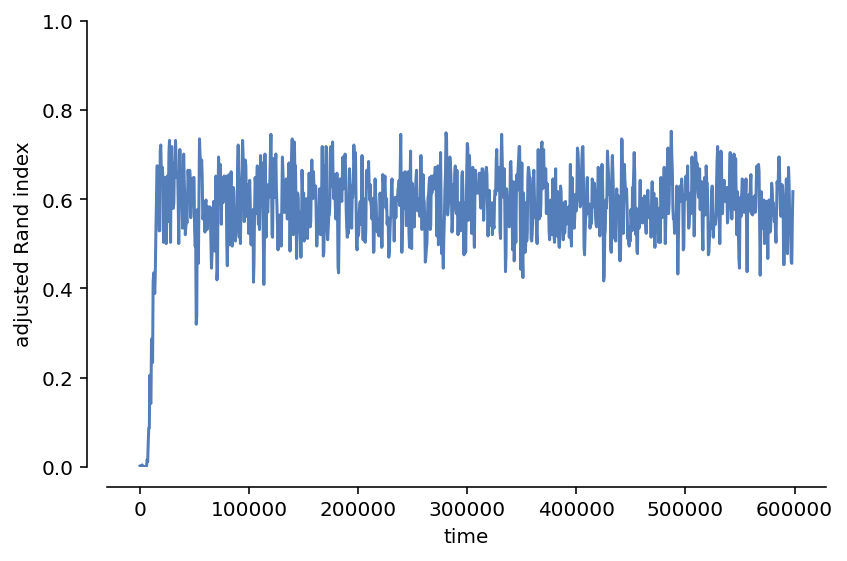

In [31]:
with FigureManager() as (_, ax):
    ax.plot(two_ar1_nonzero_mean.score_loc, two_ar1_nonzero_mean.score)
    ax.set_xlabel("time")
    ax.set_ylabel("adjusted Rand index")
    ax.set_ylim(0, 1)

In [32]:
two_ar1_nonzero_mean.score_loc_acc, two_ar1_nonzero_mean.score_acc = calculate_sliding_score(
    unordered_accuracy_score,
    two_ar1_nonzero_mean.usage_seq,
    two_ar1_nonzero_mean.inferred_usage,
    progress=tqdm,
)

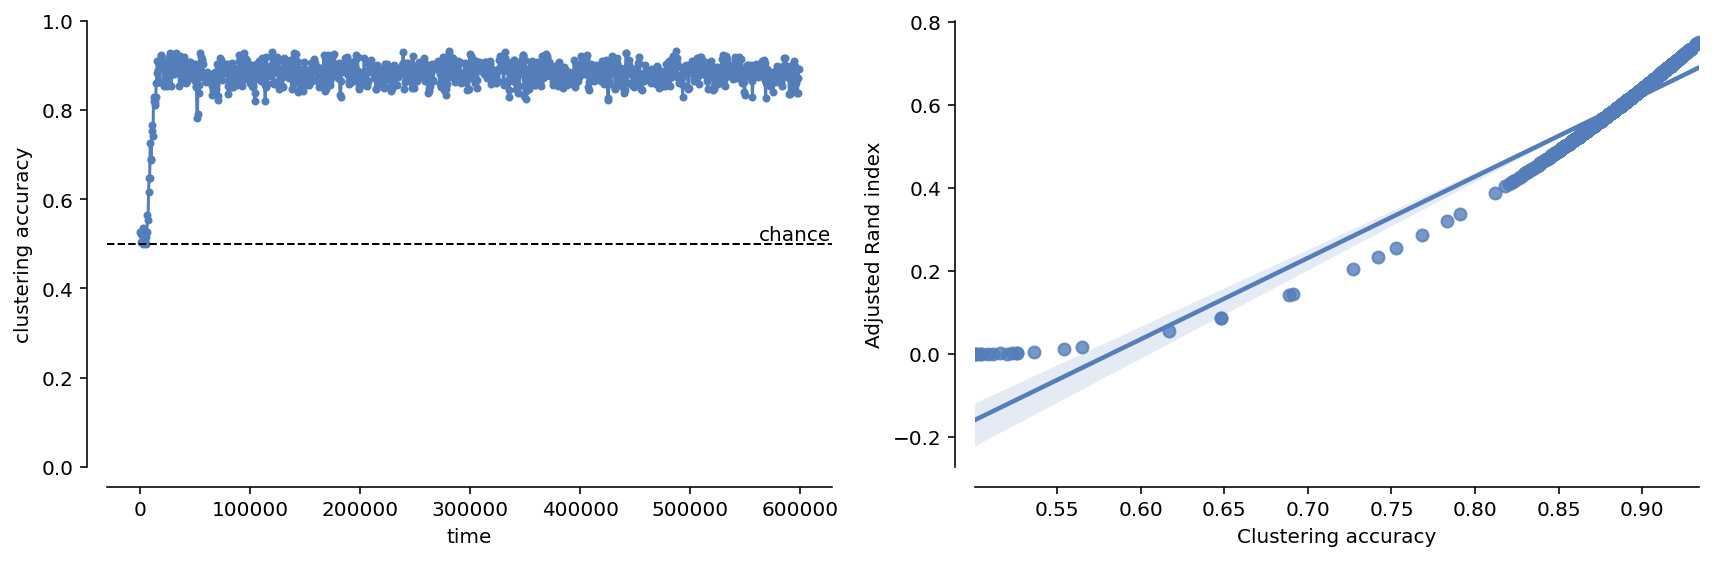

In [33]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(two_ar1_nonzero_mean.score_loc_acc, two_ar1_nonzero_mean.score_acc, ".-")
    ax1.set_xlabel("time")
    ax1.set_ylabel("clustering accuracy")
    ax1.axhline(0.5, ls="--", lw=1, c="k")
    ax1.annotate(
        "chance",
        (ax.get_xlim()[1], 0.5),
        horizontalalignment="right",
        verticalalignment="bottom",
    )
    ax1.set_ylim(0, 1)

    sns.regplot(two_ar1_nonzero_mean.score_acc, two_ar1_nonzero_mean.score, ax=ax2)
    ax2.set_xlabel("Clustering accuracy")
    ax2.set_ylabel("Adjusted Rand index")

## An example using `Dataset`

In [34]:
rng = np.random.default_rng(2)

dataset_two_arma = SimpleNamespace(
    n_signals=2,
    n_samples=500_000,
    arma_orders=[(3, 1), (2, 3)],
    fix_scale=1.0,
    n_features=5,
    streak_len=40,
)
dataset_two_arma.n_models = len(dataset_two_arma.arma_orders)
dataset_two_arma.dataset = RandomArmaDataset(
    dataset_two_arma.n_signals,
    dataset_two_arma.n_samples,
    arma_orders=dataset_two_arma.arma_orders,
    min_dwell=15,
    dwell_times=dataset_two_arma.streak_len,
    fix_scale=dataset_two_arma.fix_scale,
)

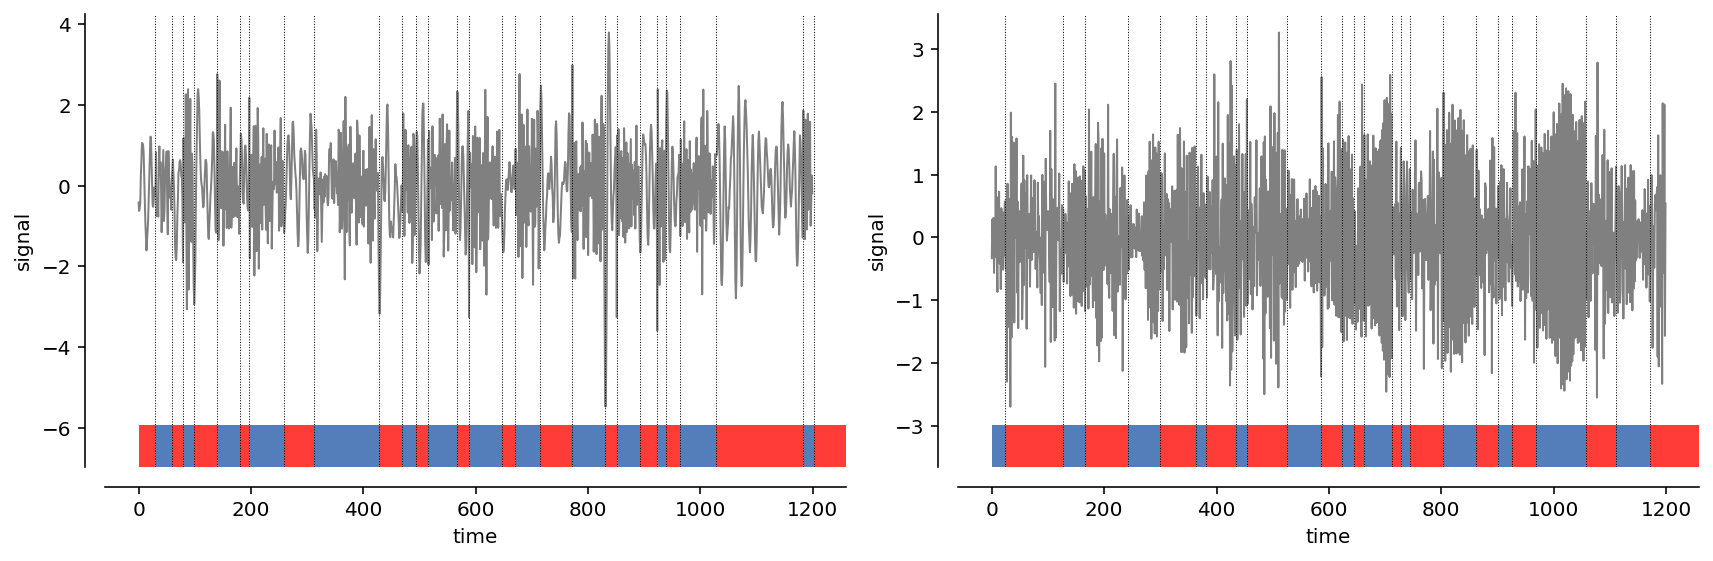

In [35]:
with FigureManager(1, dataset_two_arma.n_signals) as (_, axs):
    for ax, sig in zip(axs, dataset_two_arma.dataset):
        ax.plot(sig.y[:1200], c="gray", lw=1)
        ax.set_xlabel("time")
        ax.set_ylabel("signal")

        show_latent(sig.usage_seq, bar_location="bottom", ax=ax)

We won't use the second signal in the dataset beyond this point.

In [36]:
dataset_two_arma.sig = dataset_two_arma.dataset[0]
dataset_two_arma.regressor = BioWTARegressor(
    dataset_two_arma.n_models,
    dataset_two_arma.n_features,
    rate_weights=0.001,
    trans_mat=0.8,
)
dataset_two_arma.inferred_r, dataset_two_arma.history = fit_infer_ar(
    dataset_two_arma.regressor,
    dataset_two_arma.sig.y,
    progress=tqdm,
    monitor=["weights_"],
)
dataset_two_arma.inferred_usage = np.argmax(dataset_two_arma.inferred_r, axis=1)

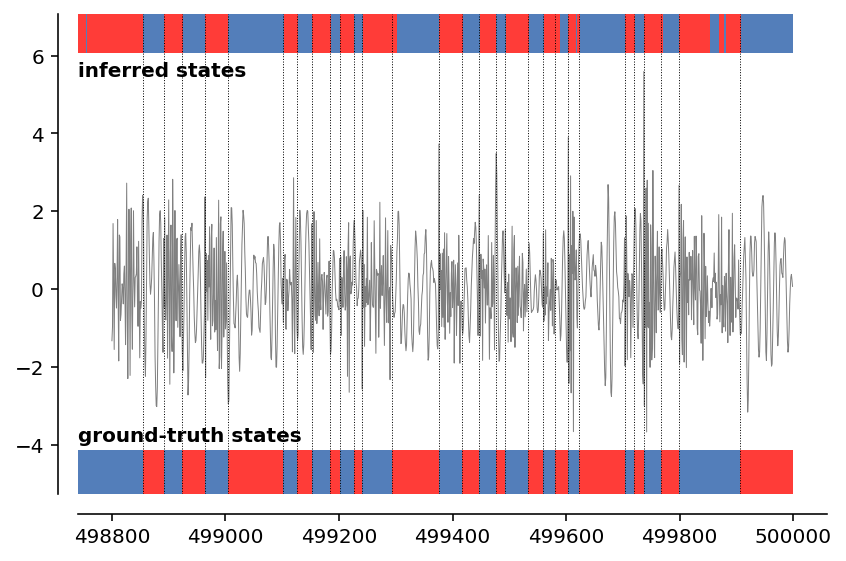

In [37]:
with FigureManager() as (_, ax):
    ax.plot(
        np.arange(dataset_two_arma.n_samples - 1200, dataset_two_arma.n_samples),
        dataset_two_arma.sig.y[-1200:],
        lw=0.5,
        c="gray",
    )
    show_latent(
        dataset_two_arma.inferred_usage,
        show_vlines=False,
        shift=dataset_two_arma.n_features,
        ax=ax,
    )
    show_latent(dataset_two_arma.sig.usage_seq, bar_location="bottom", ax=ax)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

In [38]:
dataset_two_arma.score_loc, dataset_two_arma.score = calculate_sliding_score(
    metrics.adjusted_rand_score,
    dataset_two_arma.sig.usage_seq,
    dataset_two_arma.inferred_usage,
    progress=tqdm,
)

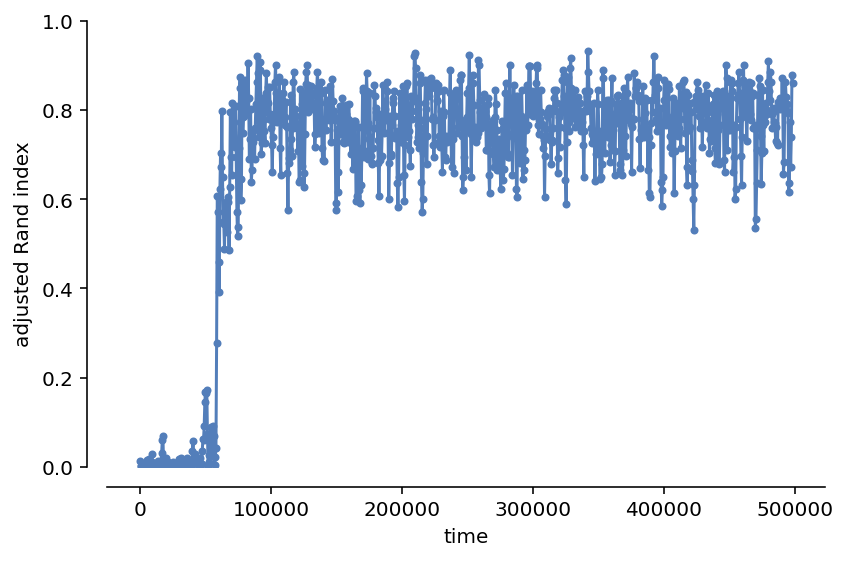

In [39]:
with FigureManager() as (_, ax):
    ax.plot(dataset_two_arma.score_loc, dataset_two_arma.score, '.-')
    ax.set_xlabel("time")
    ax.set_ylabel("adjusted Rand index")
    ax.set_ylim(0, 1)

In [40]:
dataset_two_arma.score_loc_acc, dataset_two_arma.score_acc = calculate_sliding_score(
    unordered_accuracy_score,
    dataset_two_arma.sig.usage_seq,
    dataset_two_arma.inferred_usage,
    progress=tqdm,
)

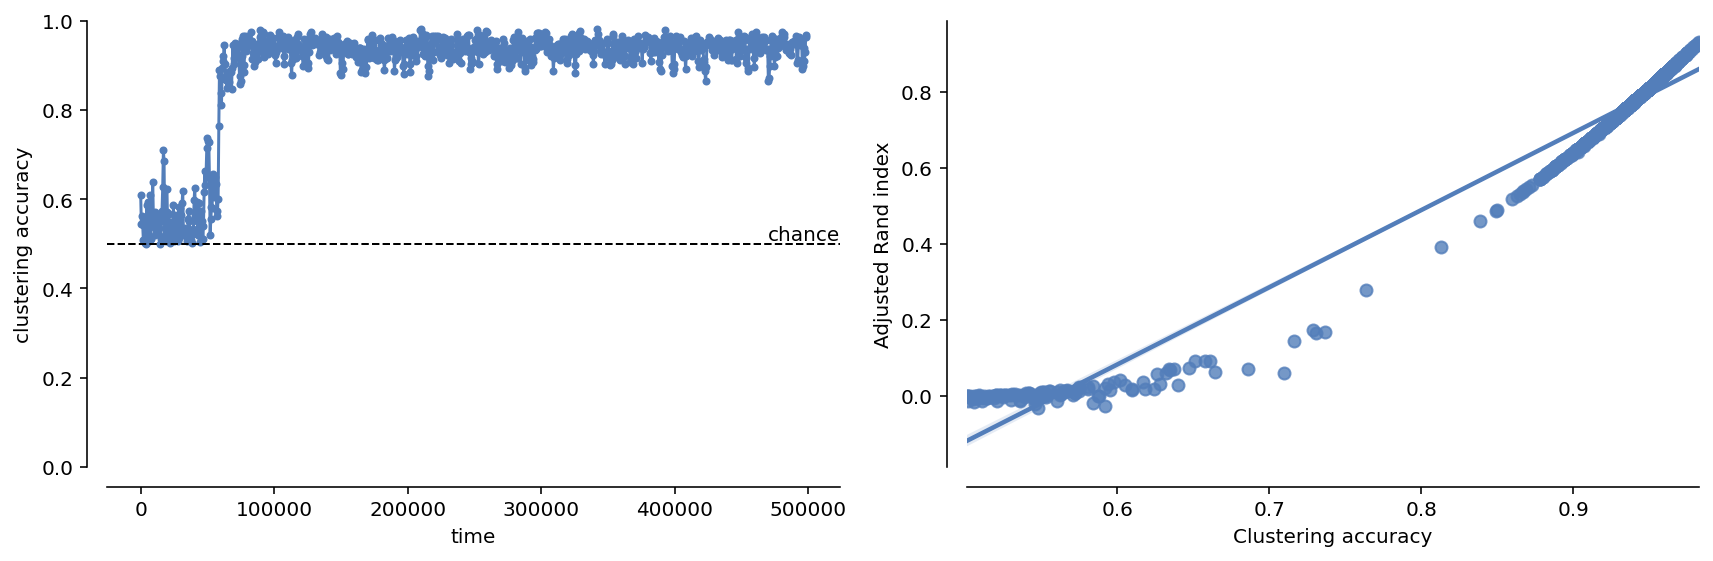

In [41]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(dataset_two_arma.score_loc_acc, dataset_two_arma.score_acc, ".-")
    ax1.set_xlabel("time")
    ax1.set_ylabel("clustering accuracy")
    ax1.axhline(0.5, ls="--", lw=1, c="k")
    ax1.annotate(
        "chance",
        (ax.get_xlim()[1], 0.5),
        horizontalalignment="right",
        verticalalignment="bottom",
    )
    ax1.set_ylim(0, 1)

    sns.regplot(dataset_two_arma.score_acc, dataset_two_arma.score, ax=ax2)
    ax2.set_xlabel("Clustering accuracy")
    ax2.set_ylabel("Adjusted Rand index")

## An example where learning fails: 3x AR(1)s with switching means

In [42]:
rng = np.random.default_rng(2)

three_ar1_nonzero_mean = SimpleNamespace(
    arma1=Arma([0.97], [], bias=1.0, default_source=sources.GaussianNoise(1)),
    arma2=Arma([0.97], [], bias=-1.0, default_source=sources.GaussianNoise(1)),
    arma3=Arma([0.97], [], bias=0.0, default_source=sources.GaussianNoise(1)),
    n_samples=600_000,
    n_features=1,
    streak_len=40,
)
three_ar1_nonzero_mean.models = [
    three_ar1_nonzero_mean.arma1,
    three_ar1_nonzero_mean.arma2,
    three_ar1_nonzero_mean.arma3,
]
three_ar1_nonzero_mean.n_models = len(three_ar1_nonzero_mean.models)
three_ar1_nonzero_mean.usage_seq = np.repeat(
    (three_ar1_nonzero_mean.n_samples // (3 * three_ar1_nonzero_mean.streak_len))
    * [0, 1, 2],
    three_ar1_nonzero_mean.streak_len,
)
(three_ar1_nonzero_mean.sig, three_ar1_nonzero_mean.u,) = sample_switching_models(
    three_ar1_nonzero_mean.models, three_ar1_nonzero_mean.usage_seq
)

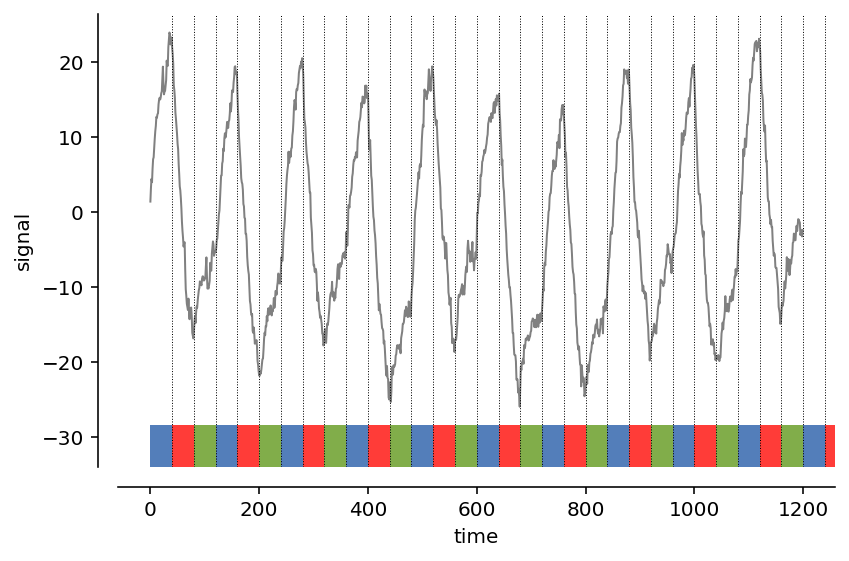

In [43]:
with FigureManager() as (_, ax):
    ax.plot(three_ar1_nonzero_mean.sig[:1200], c="gray", lw=1)
    ax.set_xlabel("time")
    ax.set_ylabel("signal")

    show_latent(three_ar1_nonzero_mean.usage_seq, bar_location="bottom", ax=ax)

Trying out some time-dependent learning rate here.

In [44]:
three_ar1_nonzero_mean.regressor = BioWTARegressor(
    three_ar1_nonzero_mean.n_models,
    three_ar1_nonzero_mean.n_features + 1,  # +1 for bias
    rate_weights=lambda i: 0.001 / (1 + 10 * i / three_ar1_nonzero_mean.n_samples),
    trans_mat=0.8,
)
three_ar1_nonzero_mean.inferred_r, three_ar1_nonzero_mean.history = fit_infer_ar(
    three_ar1_nonzero_mean.regressor,
    three_ar1_nonzero_mean.sig,
    bias=True,
    progress=tqdm,
    monitor=["weights_"],
)
three_ar1_nonzero_mean.inferred_usage = np.argmax(
    three_ar1_nonzero_mean.inferred_r, axis=1
)

Regressor inferred weights: [0.8786062  1.01547444 0.92766291]
Ground-truth: [0.97 0.97 0.97]
 
Regressor inferred biases: [-0.73883442 -0.58241081  0.9769686 ]
Ground-truth: [ 1. -1.  0.]


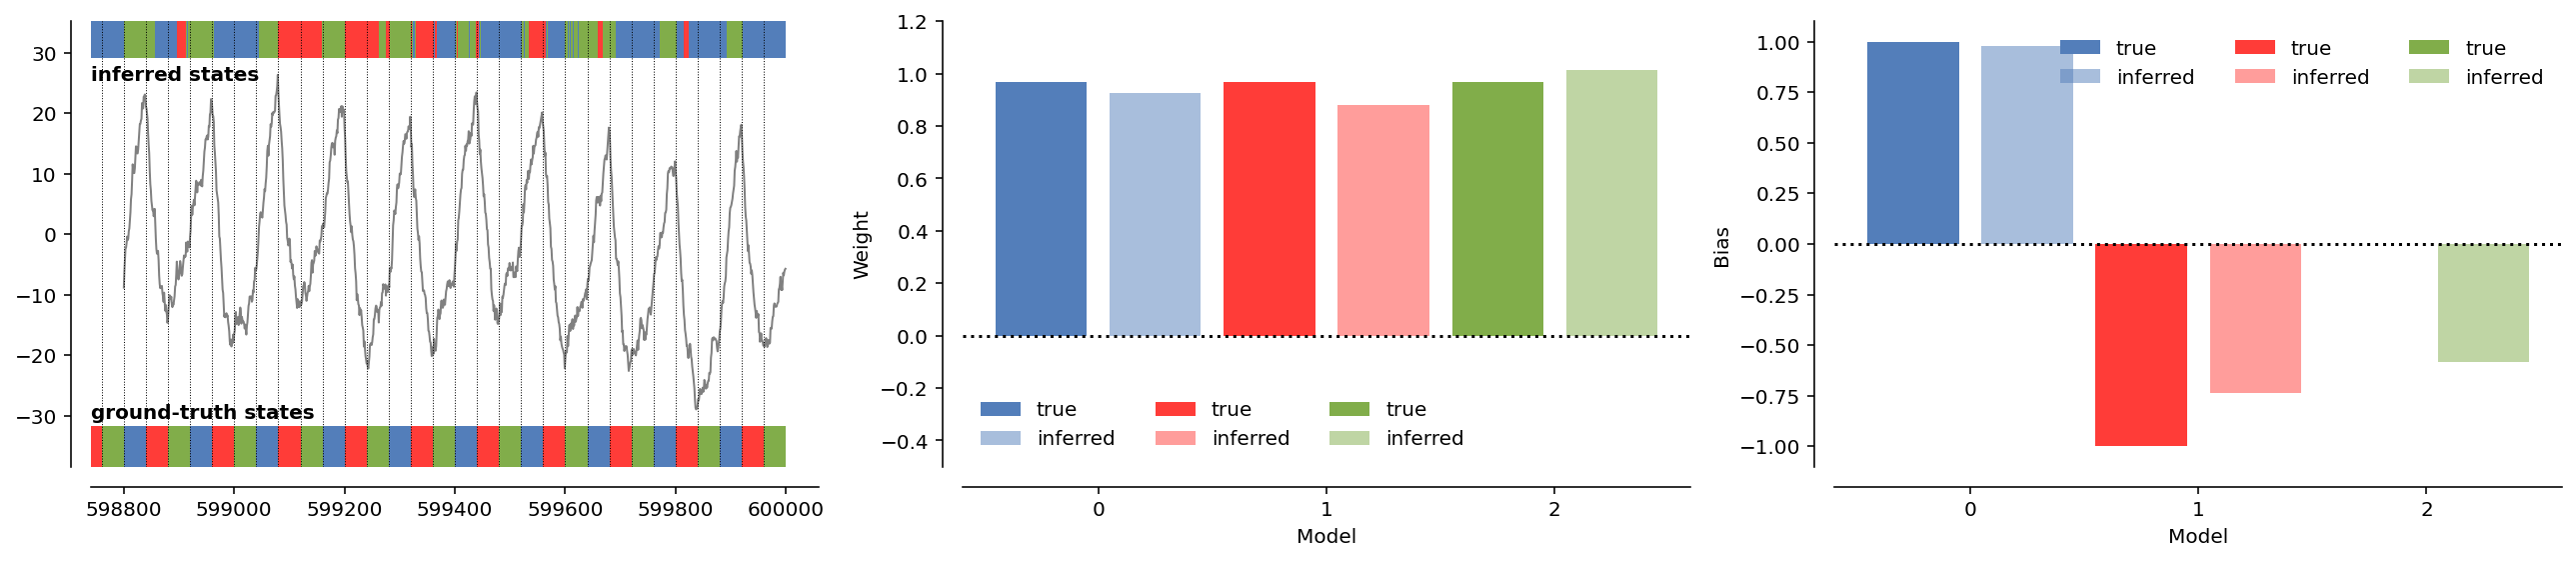

In [45]:
with FigureManager(1, 3) as (_, axs):
    axs[0].plot(
        np.arange(
            three_ar1_nonzero_mean.n_samples - 1200, three_ar1_nonzero_mean.n_samples
        ),
        three_ar1_nonzero_mean.sig[-1200:],
        c="gray",
        lw=1,
    )
    show_latent(
        three_ar1_nonzero_mean.inferred_usage,
        show_vlines=False,
        shift=three_ar1_nonzero_mean.n_features,
        ax=axs[0],
    )
    show_latent(three_ar1_nonzero_mean.usage_seq, bar_location="bottom", ax=axs[0])

    axs[0].annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    axs[0].annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

    i_matches = []
    for i in range(three_ar1_nonzero_mean.n_models):
        crt_model = [
            three_ar1_nonzero_mean.models[i].a[0],
            three_ar1_nonzero_mean.models[i].bias,
        ]

        # find fitted model that best matches the real model
        crt_corrs = np.inf * np.ones(three_ar1_nonzero_mean.n_models)
        for k in range(three_ar1_nonzero_mean.n_models):
            if k in i_matches:
                continue
            crt_corrs[k] = np.max(
                np.abs(crt_model - three_ar1_nonzero_mean.regressor.weights_[k])
            )

        i_match = crt_corrs.argmin()
        i_matches.append(i_match)

    # show AR weight
    for i in range(2):
        ax = axs[i + 1]

        if i == 0:
            crt_true = [_.a[0] for _ in three_ar1_nonzero_mean.models]
            crt_inferred = three_ar1_nonzero_mean.regressor.weights_[i_matches, 0]
        else:
            crt_true = [_.bias for _ in three_ar1_nonzero_mean.models]
            crt_inferred = three_ar1_nonzero_mean.regressor.weights_[i_matches, 1]

        for k in range(three_ar1_nonzero_mean.n_models):
            ax.bar(
                [k - 0.25], [crt_true[k]], width=0.4, label="true", color=f"C{k}",
            )
            ax.bar(
                [k + 0.25],
                [crt_inferred[k]],
                width=0.4,
                label="inferred",
                color=f"C{k}",
                alpha=0.5,
            )

        ax.axhline(0, c="k", ls=":")

        ax.legend(frameon=False, ncol=three_ar1_nonzero_mean.n_models)
        ax.set_xticks(np.arange(three_ar1_nonzero_mean.n_models))

        ax.set_xlabel("Model")

        if i == 0:
            ax.set_ylabel("Weight")
            ax.set_ylim(-0.5, 1.2)
        else:
            ax.set_ylabel("Bias")

print("Regressor inferred weights:", three_ar1_nonzero_mean.regressor.weights_[:, 0])
print("Ground-truth:", np.asarray([_.a[0] for _ in three_ar1_nonzero_mean.models]))

print(" ")

print("Regressor inferred biases:", three_ar1_nonzero_mean.regressor.weights_[:, 1])
print("Ground-truth:", np.asarray([_.bias for _ in three_ar1_nonzero_mean.models]))

In [46]:
(
    three_ar1_nonzero_mean.score_loc,
    three_ar1_nonzero_mean.score,
) = calculate_sliding_score(
    metrics.adjusted_rand_score,
    three_ar1_nonzero_mean.usage_seq,
    three_ar1_nonzero_mean.inferred_usage,
    progress=tqdm,
)

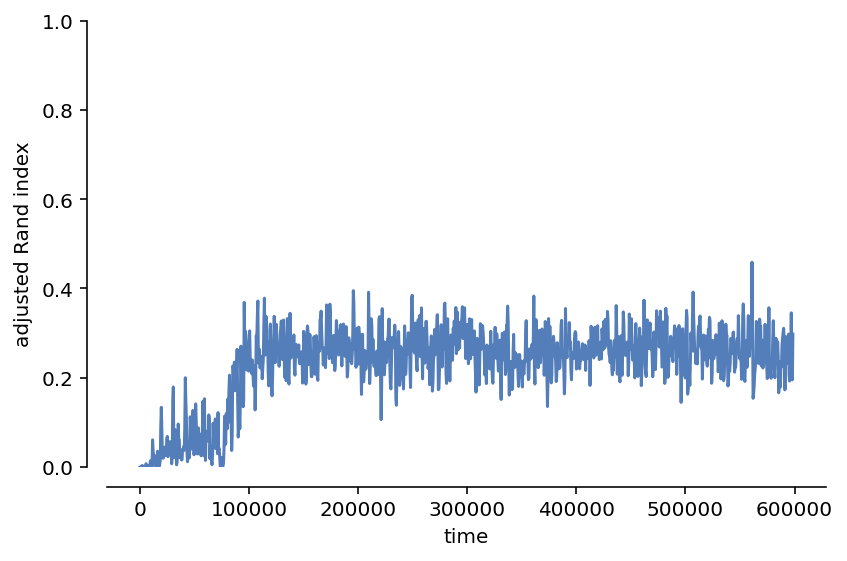

In [47]:
with FigureManager() as (_, ax):
    ax.plot(three_ar1_nonzero_mean.score_loc, three_ar1_nonzero_mean.score)
    ax.set_xlabel("time")
    ax.set_ylabel("adjusted Rand index")
    ax.set_ylim(0, 1)

In [48]:
(
    three_ar1_nonzero_mean.score_loc_acc,
    three_ar1_nonzero_mean.score_acc,
) = calculate_sliding_score(
    unordered_accuracy_score,
    three_ar1_nonzero_mean.usage_seq,
    three_ar1_nonzero_mean.inferred_usage,
    progress=tqdm,
)

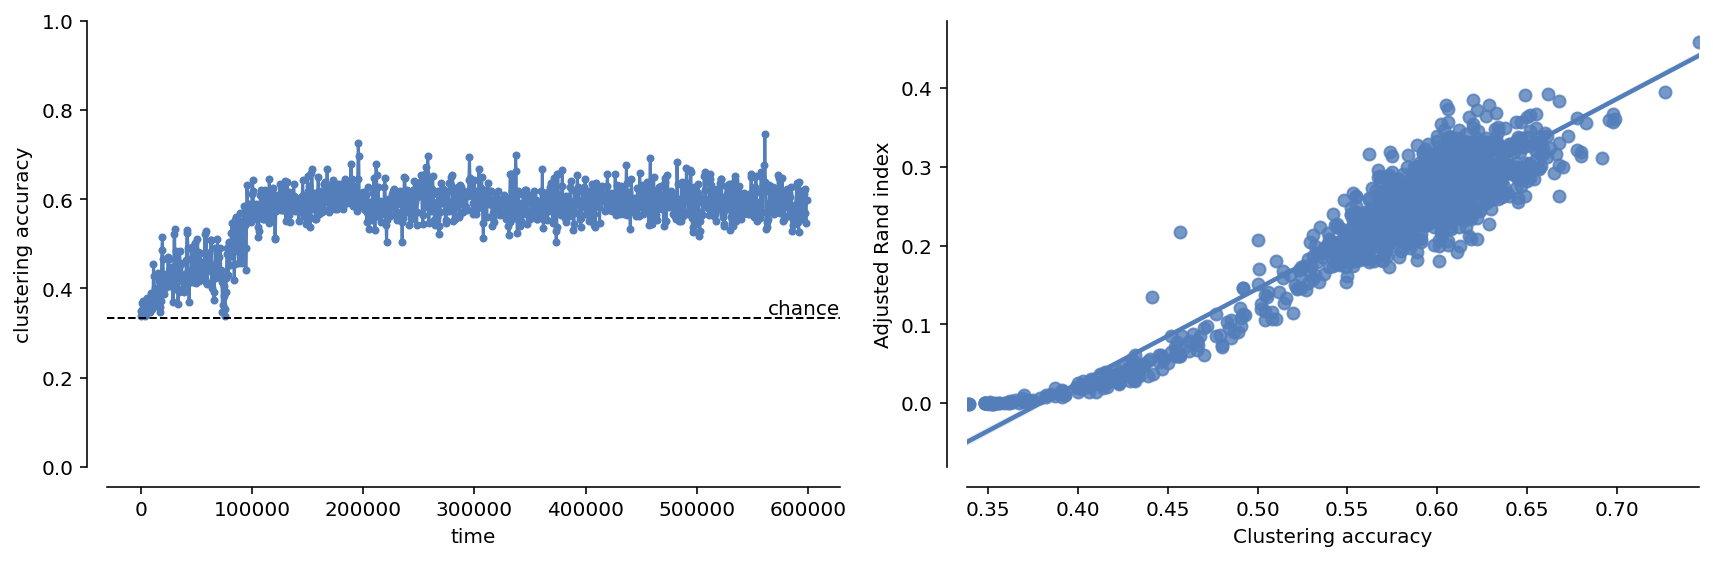

In [49]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(
        three_ar1_nonzero_mean.score_loc_acc, three_ar1_nonzero_mean.score_acc, ".-"
    )
    ax1.set_xlabel("time")
    ax1.set_ylabel("clustering accuracy")
    crt_chance = 1 / three_ar1_nonzero_mean.n_models
    ax1.axhline(crt_chance, ls="--", lw=1, c="k")
    ax1.annotate(
        "chance",
        (ax.get_xlim()[1], crt_chance),
        horizontalalignment="right",
        verticalalignment="bottom",
    )
    ax1.set_ylim(0, 1)

    sns.regplot(three_ar1_nonzero_mean.score_acc, three_ar1_nonzero_mean.score, ax=ax2)
    ax2.set_xlabel("Clustering accuracy")
    ax2.set_ylabel("Adjusted Rand index")

This is interesting: the models basically converge to the right places, but one of them is never inferred as latent state.

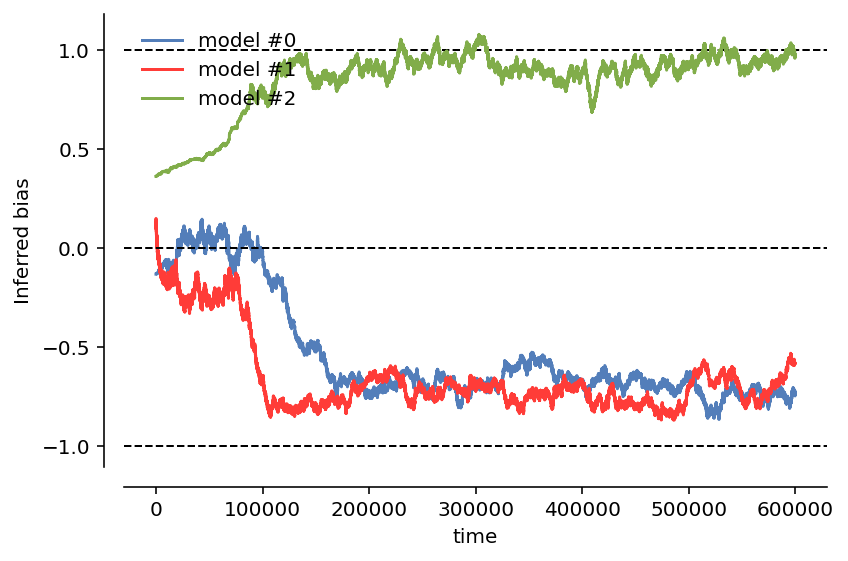

In [50]:
with FigureManager() as (_, ax):
    for i in range(three_ar1_nonzero_mean.n_models):
        ax.plot(three_ar1_nonzero_mean.history.weights_[:, i, 1], label=f"model #{i}")
        ax.axhline(three_ar1_nonzero_mean.models[i].bias, c="k", ls="--", lw=1)

    ax.set_xlabel("time")
    ax.set_ylabel("Inferred bias")
    ax.legend(frameon=False, loc="upper left")

Inferred model usage: [0.29337216 0.36032727 0.34630058]
[[0.13838069 0.12282061 0.73879869]
 [0.383375   0.494645   0.12198   ]
 [0.35836    0.463515   0.178125  ]]


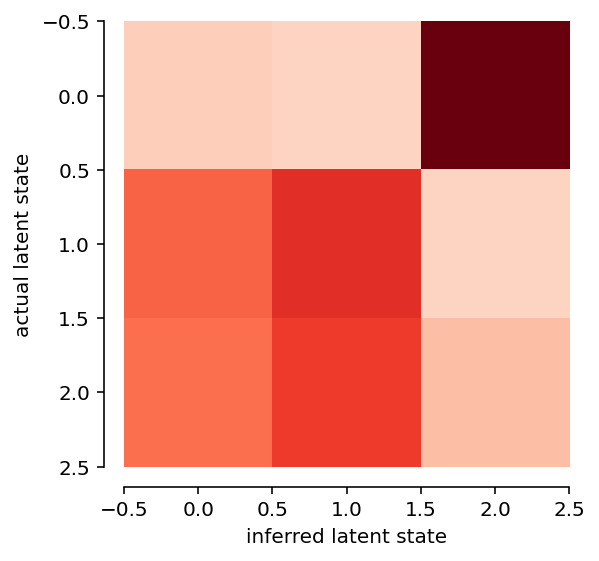

In [51]:
crt_contingency = np.zeros(
    (three_ar1_nonzero_mean.n_models, three_ar1_nonzero_mean.n_models)
)
for i in range(three_ar1_nonzero_mean.n_models):
    for j in range(three_ar1_nonzero_mean.n_models):
        crt_contingency[i, j] = np.mean(
            (three_ar1_nonzero_mean.usage_seq[three_ar1_nonzero_mean.n_features :] == i)
            & (three_ar1_nonzero_mean.inferred_usage == j)
        )
crt_contingency = crt_contingency / np.sum(crt_contingency, axis=1)[:, None]
with FigureManager() as (_, ax):
    ax.imshow(crt_contingency, vmin=0, cmap="Reds")
    ax.set_xlabel("inferred latent state")
    ax.set_ylabel("actual latent state")

print(
    "Inferred model usage:",
    np.asarray(
        [
            np.mean(three_ar1_nonzero_mean.inferred_usage == _)
            for _ in range(three_ar1_nonzero_mean.n_models)
        ]
    ),
)
print(crt_contingency)

## Benchmark `BioWTARegressor.fit_infer` speed

In [52]:
def benchmark_biowta(
    wta: BioWTARegressor,
    sample_sizes: Sequence,
    progress: Callable = None,
    n_rep: int = 3,
    random_seed: int = 0,
    kws: Optional[dict] = None,
) -> Tuple[Sequence, np.ndarray]:
    """ Benchmark speed of `BioWTARegressor.fit_infer`.
    
    This runs `BioWTARegressor.fit_infer` for different sample sizes,
    benchmarking the execution speed.
    
    Parameters
    ----------
    wta
        Semi-Markov model to benchmark.
    sample_sizes
        Sequence indicating which sample sizes to use.
    progress
        Callable to track progress.
    n_rep
        Number of times to repeat the time measurement. The first time,
        `timeit`s `autorange` is used to determine a good number of
        iterations, then `repeat` is called with `n_rep - 1` repeats
        and `number` set to the count returned by `autorange`.
    random_seed
        Seed to use for pseudorandom number generation. This is used to
        create the predictor and dependent sequences used for learning.
    kws
        Other keyword arguments to pass to `wta.fit_infer`.
    
    Returns a tuple of arrays, `(sample_sizes, times)`, with the first
    element, `sample_sizes`, simply a clone of the input argument, and the
    second element, `times`, indicating the times (in seconds) it took to
    transform each of the data sets with sizes given by `sample_sizes`. The
    timings are obtained by potentially running the task many times, using
    the `autorange` member from `timeit.Timer`.
    """
    if kws is None:
        kws = {}
    
    times = np.zeros(len(sample_sizes))
    if progress is None:
        progress = lambda it: it

    # generate a sequence long enough to work for all sample sizes
    n_samples = np.max(sample_sizes)

    rng = np.random.default_rng(random_seed)
    x = rng.normal(size=(n_samples, wta.n_features))
    y = rng.normal(size=n_samples)

    for i, n in enumerate(progress(sample_sizes)):
        wta_copy = copy.deepcopy(wta)
        timer = timeit.Timer(lambda: wta_copy.fit_infer(x[:n], y[:n], **kws))
        count, total_time = timer.autorange()

        other_times = timer.repeat(n_rep - 1, count)
        best_time = min(total_time, np.min(other_times))

        times[i] = best_time / count

    return sample_sizes, times

In [53]:
speed_test = SimpleNamespace(
    n_components=4,
    model_sizes=[
        (2, 2, None),
        (20, 3, None),
        (3, 40, None),
        (40, 40, None),
        (2, 2, 10),
        (2, 2, 10000),
    ],
    sample_sizes=np.geomspace(10, 100000, 8).astype(int),
)

speed_test.results = {}
speed_test.all_modes = BioWTARegressor._available_modes
for crt_mode in tqdm(speed_test.all_modes, desc="mode"):
    for crt_args in tqdm(speed_test.model_sizes, desc="args"):
        crt_wta = BioWTARegressor(crt_args[0], crt_args[1], rate_weights=1e-5)
        crt_wta._mode = crt_mode

        if crt_args[2] is None:
            crt_kws = None
        else:
            crt_kws = {"chunk_hint": crt_args[2]}

        crt_sizes, crt_times = benchmark_biowta(
            crt_wta, speed_test.sample_sizes, progress=tqdm, kws=crt_kws
        )

        speed_test.results[crt_mode, crt_args] = {
            "wta": crt_wta,
            "sizes": crt_sizes,
            "times": crt_times,
        }

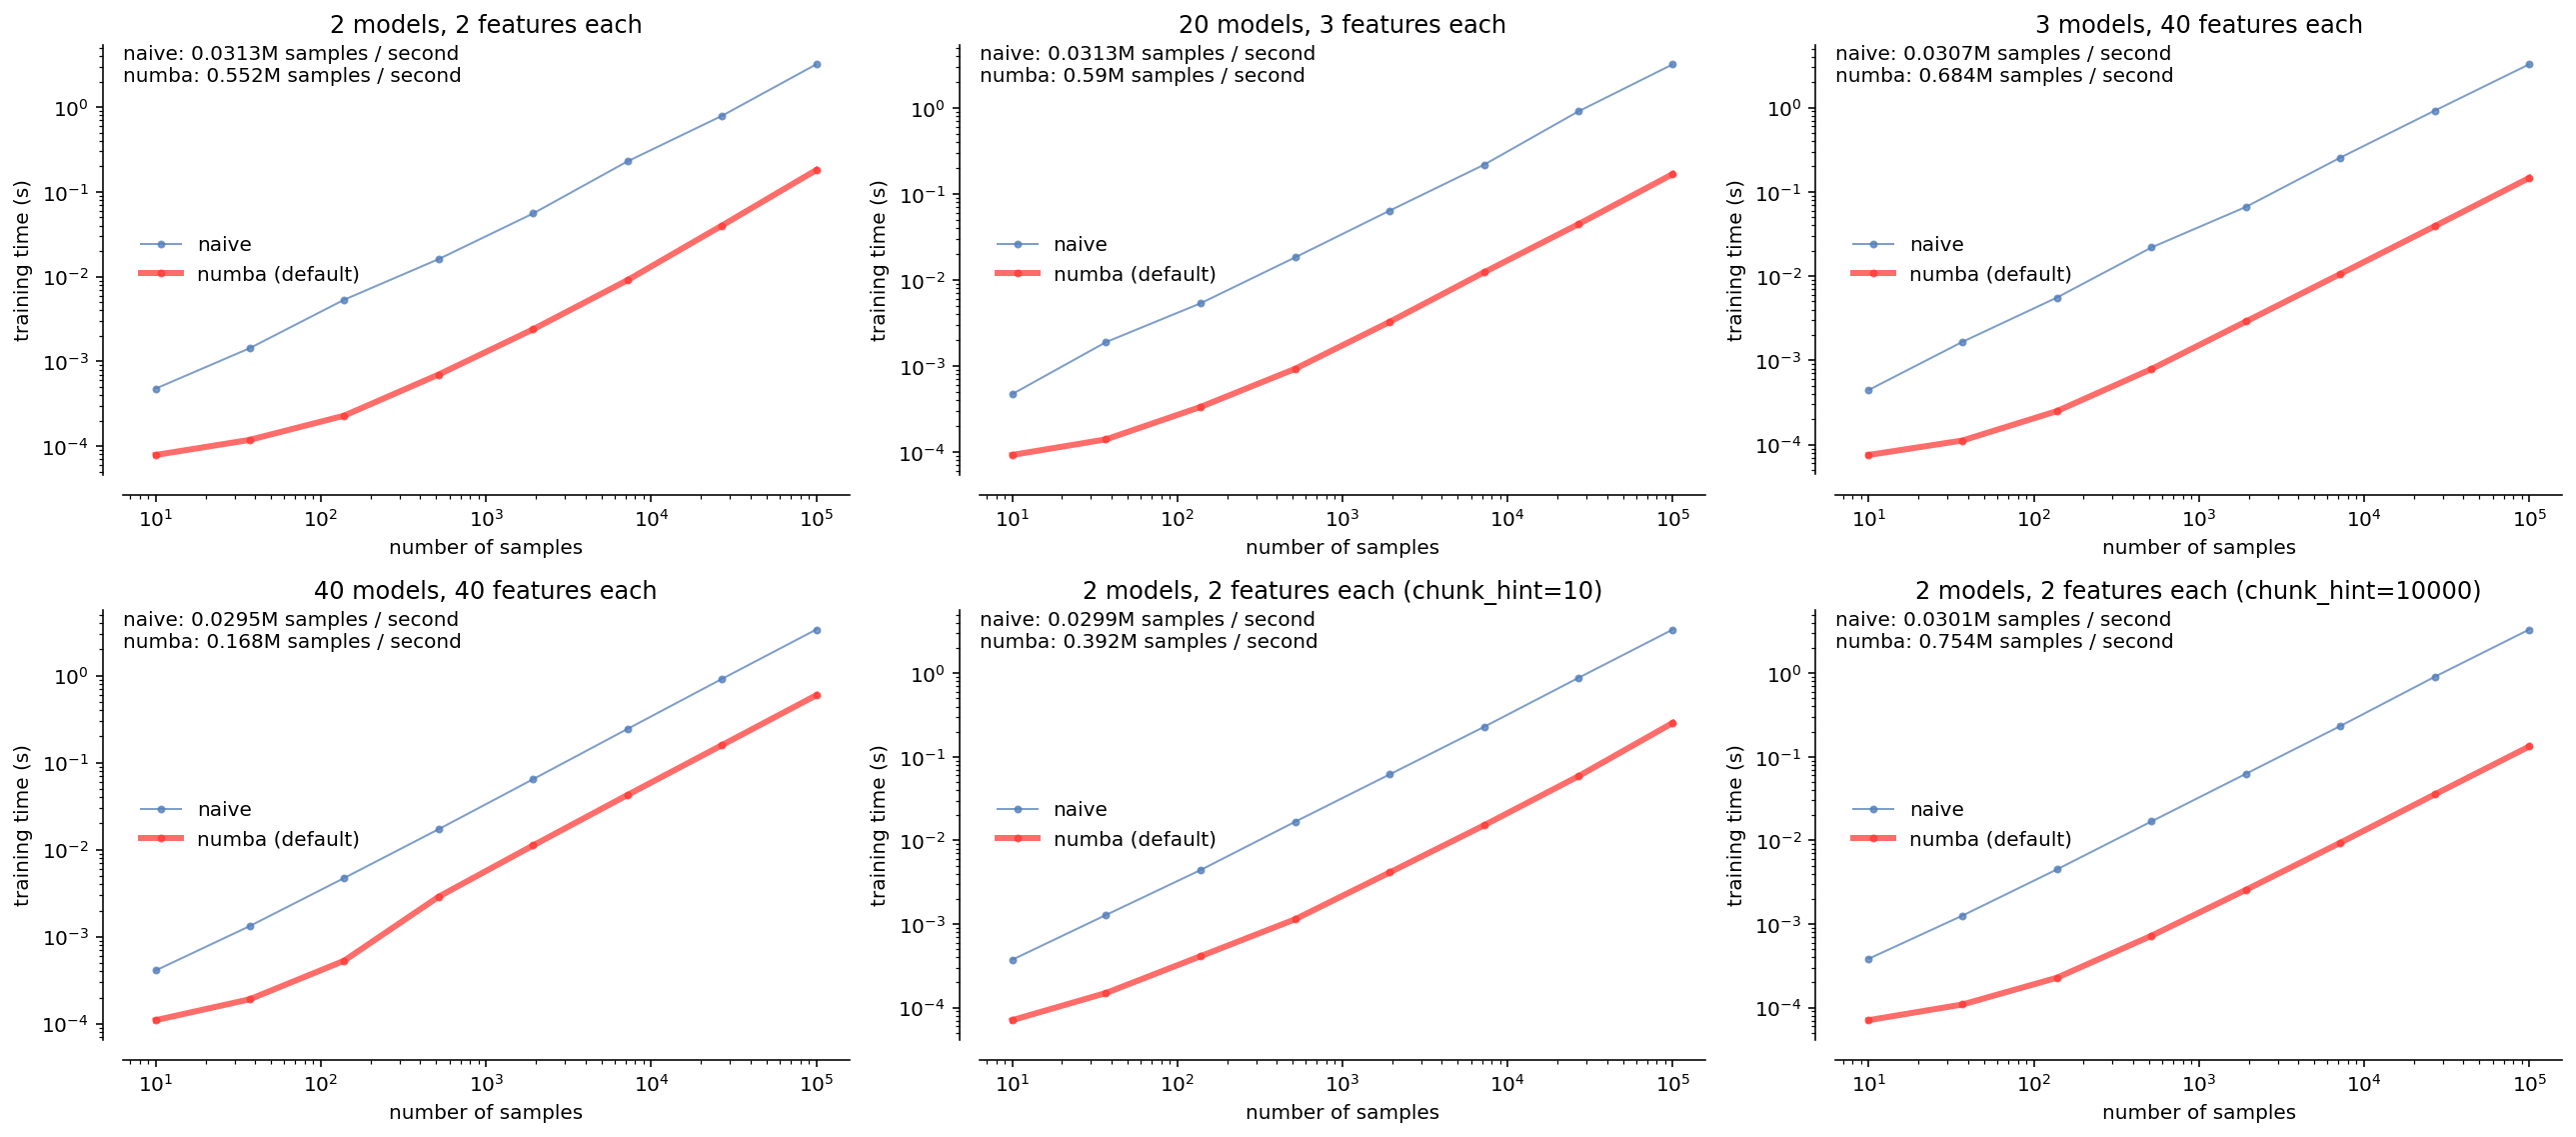

In [54]:
default_mode = BioWTARegressor(2, 2)._mode

n_rows = int(np.floor(np.sqrt(len(speed_test.model_sizes))))
n_cols = int(np.ceil(len(speed_test.model_sizes) / n_rows))
with FigureManager(n_rows, n_cols) as (_, axs):
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        crt_rates = []
        crt_annot_list = []
        crt_args = speed_test.model_sizes[i]
        for crt_mode in speed_test.all_modes:
            crt_results = speed_test.results[crt_mode, crt_args]
            is_default = crt_mode == default_mode
            if not is_default:
                crt_mode_label = crt_mode
            else:
                crt_mode_label = crt_mode + " (default)"
                
            ax.loglog(
                crt_results["sizes"],
                crt_results["times"],
                ".-",
                label=crt_mode_label,
                alpha=0.75,
                lw=3 if is_default else 1,
            )

            crt_rate = crt_results["sizes"][-1] / crt_results["times"][-1] / 1000000
            crt_rates.append(crt_rate)
            crt_annot_list.append(f"{crt_mode}: {crt_rate:.3g}M samples / second")

        crt_title = f"{crt_args[0]} models, {crt_args[1]} features each"
        if crt_args[2] is not None:
            crt_title += f" (chunk_hint={crt_args[2]})"
        ax.set_title(crt_title)
        ax.legend(frameon=False, loc="center left")

        ax.set_xlabel("number of samples")
        ax.set_ylabel("training time (s)")

        crt_annot = "\n".join(crt_annot_list)
        ax.annotate(
            crt_annot, (0.0, 1.0), xycoords="axes fraction", verticalalignment="top"
        )